### Movie Recommendation System 

In [1]:
####packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import Markdown, display
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.metrics.pairwise import *

#### Data

##### 1) User

In [2]:
###data
userData=pd.read_csv('Data\\ml-100k\\u.user',sep='|',header=None,names=['user id','age','gender','occupation','zip code'])
userData.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [3]:
def summarize(df):
    head_df=df.head()
    df_col=df.columns
    shape=df.shape
    dtypes=df.dtypes
    summ=df.describe(include='all')
    return (head_df,df_col,shape,dtypes,summ)


In [4]:
(head_df,df_col,shape,dtypes,summ)=summarize(userData)
print('First few rows:\n',head_df)
print('Columns:\n',df_col)
print('Df shape:\n',shape)
print('Datatypes:\n',dtypes)
print('Summary:\n',summ)

First few rows:
    user id  age gender  occupation zip code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213
Columns:
 Index(['user id', 'age', 'gender', 'occupation', 'zip code'], dtype='object')
Df shape:
 (943, 5)
Datatypes:
 user id        int64
age            int64
gender        object
occupation    object
zip code      object
dtype: object
Summary:
            user id         age gender occupation zip code
count   943.000000  943.000000    943        943      943
unique         NaN         NaN      2         21      795
top            NaN         NaN      M    student    55414
freq           NaN         NaN    670        196        9
mean    472.000000   34.051962    NaN        NaN      NaN
std     272.364951   12.192740    NaN        NaN      NaN
min       1.000000    7.000000    NaN        NaN      NaN
25%   

In [5]:
def detect_outlier(col):
    out=[]
    threshold=3
    mean_1 = np.mean(col)
    std_1 =np.std(col)
    for y in col:
        z_score= (y - mean_1)/std_1
        if np.abs(z_score) > threshold:
            out.append(y)
#     print('Outliers:',out)
    if out is not None:
        return out
    else:
        return 0

In [6]:
def preprocess_nullout(df):
    #null values\n",
    null=dict.fromkeys(df.columns)
    print(null.keys())
    for col in df.columns:
        null[col]=df[col].isna().sum()
        if(null[col]!=0):
             print('Column:',col,'Null records:',df.loc[df[col].isna()])
    print(null)
    #outliers\n",
    outliers=dict.fromkeys(df.columns)
    print(outliers.keys())
    for col in df.columns:
        if((df[col].dtypes=='int64')|(df[col].dtypes=='float64')):
            print(col)
            out=detect_outlier(df[col])
            if out:
                print('Outliers detected:',out)
                print('Records containing outliers:\n',df.loc[df[col]==out[0]])
            else:
                print("Outliers not detecred")
                

In [7]:
preprocess_nullout(userData)

dict_keys(['user id', 'age', 'gender', 'occupation', 'zip code'])
{'user id': 0, 'age': 0, 'gender': 0, 'occupation': 0, 'zip code': 0}
dict_keys(['user id', 'age', 'gender', 'occupation', 'zip code'])
user id
Outliers not detecred
age
Outliers detected: [73]
Records containing outliers:
      user id  age gender occupation zip code
480      481   73      M    retired    37771


In [8]:
####unique values for string col
for col in userData.columns:
    if(userData[col].dtypes=='object'):
        print(col)
        print(userData[col].unique())
        print(len(userData[col].unique()))

gender
['M' 'F']
2
occupation
['technician' 'other' 'writer' 'executive' 'administrator' 'student'
 'lawyer' 'educator' 'scientist' 'entertainment' 'programmer' 'librarian'
 'homemaker' 'artist' 'engineer' 'marketing' 'none' 'healthcare' 'retired'
 'salesman' 'doctor']
21
zip code
['85711' '94043' '32067' '43537' '15213' '98101' '91344' '05201' '01002'
 '90703' '30329' '06405' '29206' '55106' '97301' '10309' '06355' '37212'
 '02138' '95660' '30068' '40206' '48197' '94533' '55107' '21044' '30030'
 '55369' '55436' '10003' '78741' '27510' '42141' '42459' '93117' '55105'
 '54467' '01040' '27514' '80525' '17870' '20854' '46260' '50233' '46538'
 '07102' '12550' '76111' '52245' '16509' '55414' '66315' '01331' '84010'
 '52246' '08403' '06472' '30040' '97214' '75240' '43202' '48118' '80521'
 '60402' '22904' '55337' '60067' '98034' '73034' '41850' 'T8H1N' '08816'
 '02215' '29379' '61801' '03755' '52241' '21218' '22902' '44133' '20003'
 '46005' '89503' '11701' '68106' '78155' '01913' '23112' '714

#### Vizualization

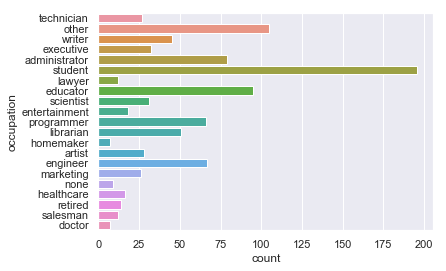

In [9]:
##### OCCUPATION
sns.set(style="darkgrid")
ax=sns.countplot(data=userData, y='occupation')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000764B6D81D0>]],
      dtype=object)

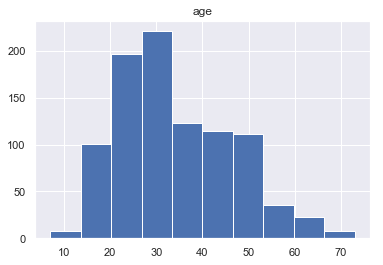

In [10]:
##### AGE
sns.set(style="darkgrid")
userData.hist(column='age',bins=10)

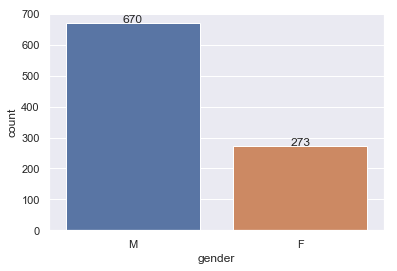

In [11]:
#### GENDER
sns.set(style="darkgrid")
ax=sns.countplot(data=userData, x='gender')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            '{:1.0f}'.format(height),
            ha="center") 
plt.show()

#### Group by results

In [12]:
### get the users from same area
df=userData.groupby(['zip code'])['user id'].count().reset_index(name='count')
df[df['count']>2]

,zip code,count
31,02215,3
88,10003,5
94,10021,3
105,11217,3
125,14216,3
172,20009,5
207,22902,3
208,22903,3
230,27514,4
361,48103,3


In [13]:
### get users from same age
userData.groupby(['age'])['user id'].count()

age
7      1
10     1
11     1
13     5
14     3
15     6
16     5
17    14
18    18
19    23
20    32
21    27
22    37
23    28
24    33
25    38
26    34
27    35
28    36
29    32
30    39
31    25
32    28
33    26
34    17
35    27
36    21
37    19
38    17
39    22
      ..
41    10
42    21
43    13
44    23
45    15
46    12
47    14
48    20
49    19
50    20
51    20
52     6
53    12
54     4
55    11
56     6
57     9
58     3
59     3
60     9
61     3
62     2
63     3
64     2
65     3
66     1
68     2
69     2
70     3
73     1
Name: user id, Length: 61, dtype: int64

In [14]:
### get users from same occupation
userData.groupby(['occupation'])['user id'].count()

occupation
administrator     79
artist            28
doctor             7
educator          95
engineer          67
entertainment     18
executive         32
healthcare        16
homemaker          7
lawyer            12
librarian         51
marketing         26
none               9
other            105
programmer        66
retired           14
salesman          12
scientist         31
student          196
technician        27
writer            45
Name: user id, dtype: int64

In [15]:
### get users from same gender
userData.groupby(['gender'])['user id'].count()

gender
F    273
M    670
Name: user id, dtype: int64

#### Clustering to find neighbors of users

#### Clusters according to age group -4

In [16]:
######binning age values in interval of 20
df=pd.DataFrame()
df['age']=userData['age']
df['bin'] = pd.cut(userData['age'],[i for i in range(0,100,20)], labels=['0-20', '20-40', '40-60','60-80']) #category

In [17]:
userData['Age_category']=df['bin']

In [18]:
userData.groupby(['Age_category'])['user id'].count()

Age_category
0-20     109
20-40    562
40-60    250
60-80     22
Name: user id, dtype: int64

In [19]:
def printmd(string):
    display(Markdown(string))
printmd('**bold**')

**bold**

In [20]:
i=1
for cat in userData.Age_category.unique():
    printmd(f'**Cluster {i} Age group :{cat}**\n')
    res=userData.loc[userData['Age_category']==cat]
    print(f'Record count: {res.shape[0]}')
    print(res)
    print('\n')
    i=i+1

**Cluster 1 Age group :20-40**


Record count: 562
     user id  age gender     occupation zip code Age_category
0          1   24      M     technician    85711        20-40
2          3   23      M         writer    32067        20-40
3          4   24      M     technician    43537        20-40
4          5   33      F          other    15213        20-40
7          8   36      M  administrator    05201        20-40
8          9   29      M        student    01002        20-40
10        11   39      F          other    30329        20-40
11        12   28      F          other    06405        20-40
15        16   21      M  entertainment    10309        20-40
16        17   30      M     programmer    06355        20-40
17        18   35      F          other    37212        20-40
18        19   40      M      librarian    02138        20-40
20        21   26      M         writer    30068        20-40
21        22   25      M         writer    40206        20-40
22        23   30      F         artist    48197    

**Cluster 2 Age group :40-60**


Record count: 250
     user id  age gender     occupation zip code Age_category
1          2   53      F          other    94043        40-60
5          6   42      M      executive    98101        40-60
6          7   57      M  administrator    91344        40-60
9         10   53      M         lawyer    90703        40-60
12        13   47      M       educator    29206        40-60
13        14   45      M      scientist    55106        40-60
14        15   49      F       educator    97301        40-60
19        20   42      F      homemaker    95660        40-60
25        26   49      M       engineer    21044        40-60
28        29   41      M     programmer    94043        40-60
38        39   41      M  entertainment    01040        40-60
46        47   53      M      marketing    07102        40-60
47        48   45      M  administrator    12550        40-60
58        59   49      M       educator    08403        40-60
59        60   50      M     healthcare    06472    

**Cluster 3 Age group :0-20**


Record count: 109
     user id  age gender     occupation zip code Age_category
29        30    7      M        student    55436         0-20
34        35   20      F      homemaker    42459         0-20
35        36   19      F        student    93117         0-20
51        52   18      F        student    55105         0-20
56        57   16      M           none    84010         0-20
66        67   17      M        student    60402         0-20
67        68   19      M        student    22904         0-20
75        76   20      M        student    02215         0-20
98        99   20      M        student    63129         0-20
100      101   15      M        student    05146         0-20
109      110   19      M        student    77840         0-20
116      117   20      M        student    16125         0-20
129      130   20      M           none    60115         0-20
138      139   20      M        student    08904         0-20
141      142   13      M          other    48118    

**Cluster 4 Age group :60-80**


Record count: 22
     user id  age gender     occupation zip code Age_category
105      106   61      M        retired    55125        60-80
210      211   66      M       salesman    32605        60-80
265      266   62      F  administrator    78756        60-80
317      318   65      M        retired    06518        60-80
348      349   68      M        retired    61455        60-80
350      351   61      M       educator    49938        60-80
363      364   63      M       engineer    01810        60-80
422      423   64      M          other    91606        60-80
480      481   73      M        retired    37771        60-80
519      520   62      M     healthcare    12603        60-80
558      559   69      M      executive    10022        60-80
563      564   65      M        retired    94591        60-80
572      573   68      M        retired    48911        60-80
584      585   69      M      librarian    98501        60-80
650      651   65      M        retired    02903     

#### Clusters according to gender - 2

In [21]:
i=1
for gen in userData.gender.unique():
    printmd(f'**Cluster {i} Group :{gen}**\n')
    res=userData.loc[userData['gender']==gen]
    print(f'Record count: {res.shape[0]}')
    print(res)
    print('\n')
    i=i+1

**Cluster 1 Group :M**


Record count: 670
     user id  age gender     occupation zip code Age_category
0          1   24      M     technician    85711        20-40
2          3   23      M         writer    32067        20-40
3          4   24      M     technician    43537        20-40
5          6   42      M      executive    98101        40-60
6          7   57      M  administrator    91344        40-60
7          8   36      M  administrator    05201        20-40
8          9   29      M        student    01002        20-40
9         10   53      M         lawyer    90703        40-60
12        13   47      M       educator    29206        40-60
13        14   45      M      scientist    55106        40-60
15        16   21      M  entertainment    10309        20-40
16        17   30      M     programmer    06355        20-40
18        19   40      M      librarian    02138        20-40
20        21   26      M         writer    30068        20-40
21        22   25      M         writer    40206    

**Cluster 2 Group :F**


Record count: 273
     user id  age gender     occupation zip code Age_category
1          2   53      F          other    94043        40-60
4          5   33      F          other    15213        20-40
10        11   39      F          other    30329        20-40
11        12   28      F          other    06405        20-40
14        15   49      F       educator    97301        40-60
17        18   35      F          other    37212        20-40
19        20   42      F      homemaker    95660        40-60
22        23   30      F         artist    48197        20-40
23        24   21      F         artist    94533        20-40
26        27   40      F      librarian    30030        20-40
31        32   28      F        student    78741        20-40
33        34   38      F  administrator    42141        20-40
34        35   20      F      homemaker    42459         0-20
35        36   19      F        student    93117         0-20
37        38   28      F          other    54467    

In [22]:
labelencoder = LabelEncoder()
userData['gen']= labelencoder.fit_transform(userData['gender'])

In [23]:
userData['gen'].head() #male-1 

0    1
1    0
2    1
3    1
4    0
Name: gen, dtype: int32

In [47]:
# X=userData[['gen']]

In [48]:
# km=KMeans(n_clusters=2)
# y_means=km.fit_predict(X)

In [51]:
# X=userData.loc[:,'gen'].values.reshape(-1, 1)
# X=userData[['gen']]
# # #Visualizing the clusters for k=2
# plt.scatter(X.iloc[y_means==0,0],s=50, c='purple',label='Cluster1')
# # plt.scatter(X.iloc[y_means==1,1],X.iloc[y_means==1,0],s=50, c='blue',label='Cluster2')
# # plt.scatter(X.iloc[ymeans==2,1],X.iloc[y_means==2,0],s=50, c='green',label='Cluster3')
# # plt.scatter(X.iloc[ymeans==3,1],X.iloc[y_means==3,0],s=50, c='cyan',label='Cluster4')
# plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
# plt.title('Customer segments')
# plt.xlabel('Gender')
# plt.ylabel('y')
# plt.legend()
# plt.show()

#### Clusters according to occupation- 21

In [24]:
i=1
for occ in userData.occupation.unique():
    printmd(f'**Cluster {i} Group :{occ}**\n')
    res=userData.loc[userData['occupation']==occ]
    print(f'Record count: {res.shape[0]}')
    print(res)
    print('\n')
    i=i+1

**Cluster 1 Group :technician**


Record count: 27
     user id  age gender  occupation zip code Age_category  gen
0          1   24      M  technician    85711        20-40    1
3          4   24      M  technician    43537        20-40    1
43        44   26      M  technician    46260        20-40    1
76        77   30      M  technician    29379        20-40    1
142      143   42      M  technician    08832        40-60    1
196      197   55      M  technician    75094        40-60    1
243      244   28      M  technician    80525        20-40    1
293      294   34      M  technician    92110        20-40    1
310      311   32      M  technician    73071        20-40    1
324      325   48      M  technician    02139        40-60    1
440      441   50      M  technician    55013        40-60    1
455      456   24      M  technician    31820        20-40    1
457      458   47      M  technician    Y1A6B        40-60    1
487      488   48      M  technician    21012        40-60    1
544      545   27      

**Cluster 2 Group :other**


Record count: 105
     user id  age gender occupation zip code Age_category  gen
1          2   53      F      other    94043        40-60    0
4          5   33      F      other    15213        20-40    0
10        11   39      F      other    30329        20-40    0
11        12   28      F      other    06405        20-40    0
17        18   35      F      other    37212        20-40    0
37        38   28      F      other    54467        20-40    0
82        83   40      M      other    44133        20-40    1
108      109   29      M      other    55423        20-40    1
119      120   47      F      other    06260        40-60    0
131      132   24      M      other    94612        20-40    1
135      136   51      M      other    97365        40-60    1
141      142   13      M      other    48118         0-20    1
154      155   32      F      other    11217        20-40    0
164      165   20      F      other    53715         0-20    0
166      167   37      M      other  

**Cluster 3 Group :writer**


Record count: 45
     user id  age gender occupation zip code Age_category  gen
2          3   23      M     writer    32067        20-40    1
20        21   26      M     writer    30068        20-40    1
21        22   25      M     writer    40206        20-40    1
27        28   32      M     writer    55369        20-40    1
49        50   21      M     writer    52245        20-40    1
121      122   32      F     writer    22206        20-40    0
195      196   49      M     writer    55105        40-60    1
198      199   30      M     writer    17604        20-40    1
200      201   27      M     writer    E2A4H        20-40    1
235      236   44      F     writer    53214        40-60    0
263      264   36      F     writer    90064        20-40    0
292      293   24      M     writer    60804        20-40    1
369      370   52      M     writer    08534        40-60    1
384      385   36      M     writer    10003        20-40    1
388      389   44      F     writer   

**Cluster 4 Group :executive**


Record count: 32
     user id  age gender occupation zip code Age_category  gen
5          6   42      M  executive    98101        40-60    1
53        54   22      M  executive    66315        20-40    1
83        84   32      M  executive    55369        20-40    1
92        93   48      M  executive    23112        40-60    1
97        98   49      F  executive    90291        40-60    0
99       100   36      M  executive    90254        20-40    1
112      113   47      M  executive    95032        40-60    1
180      181   26      M  executive    21218        20-40    1
185      186   39      F  executive    00000        20-40    0
212      213   33      M  executive    55345        20-40    1
226      227   46      M  executive    60659        40-60    1
249      250   29      M  executive    95110        20-40    1
264      265   26      M  executive    84601        20-40    1
283      284   40      M  executive    92629        20-40    1
297      298   44      M  executive   

**Cluster 5 Group :administrator**


Record count: 79
     user id  age gender     occupation zip code Age_category  gen
6          7   57      M  administrator    91344        40-60    1
7          8   36      M  administrator    05201        20-40    1
33        34   38      F  administrator    42141        20-40    0
41        42   30      M  administrator    17870        20-40    1
47        48   45      M  administrator    12550        40-60    1
61        62   27      F  administrator    97214        20-40    0
71        72   48      F  administrator    73034        40-60    0
77        78   26      M  administrator    61801        20-40    1
78        79   39      F  administrator    03755        20-40    0
79        80   34      F  administrator    52241        20-40    0
85        86   26      M  administrator    46005        20-40    1
86        87   47      M  administrator    89503        40-60    1
88        89   43      F  administrator    68106        40-60    0
94        95   31      M  administrator    10

**Cluster 6 Group :student**


Record count: 196
     user id  age gender occupation zip code Age_category  gen
8          9   29      M    student    01002        20-40    1
29        30    7      M    student    55436         0-20    1
31        32   28      F    student    78741        20-40    0
32        33   23      M    student    27510        20-40    1
35        36   19      F    student    93117         0-20    0
36        37   23      M    student    55105        20-40    1
48        49   23      F    student    76111        20-40    0
51        52   18      F    student    55105         0-20    0
65        66   23      M    student    80521        20-40    1
66        67   17      M    student    60402         0-20    1
67        68   19      M    student    22904         0-20    1
72        73   24      M    student    41850        20-40    1
75        76   20      M    student    02215         0-20    1
80        81   21      M    student    21218        20-40    1
93        94   26      M    student  

**Cluster 7 Group :lawyer**


Record count: 12
     user id  age gender occupation zip code Age_category  gen
9         10   53      M     lawyer    90703        40-60    1
124      125   30      M     lawyer    22202        20-40    1
125      126   28      F     lawyer    20015        20-40    0
160      161   50      M     lawyer    55104        40-60    1
204      205   47      M     lawyer    06371        40-60    1
338      339   35      M     lawyer    37901        20-40    1
364      365   29      M     lawyer    20009        20-40    1
418      419   37      M     lawyer    43215        20-40    1
443      444   51      F     lawyer    53202        40-60    0
588      589   21      M     lawyer    90034        20-40    1
679      680   33      M     lawyer    90405        20-40    1
845      846   27      M     lawyer    47130        20-40    1




**Cluster 8 Group :educator**


Record count: 95
     user id  age gender occupation zip code Age_category  gen
12        13   47      M   educator    29206        40-60    1
14        15   49      F   educator    97301        40-60    0
50        51   28      M   educator    16509        20-40    1
58        59   49      M   educator    08403        40-60    1
63        64   32      M   educator    43202        20-40    1
64        65   51      F   educator    48118        40-60    0
84        85   51      M   educator    20003        40-60    1
89        90   60      M   educator    78155        40-60    1
107      108   44      M   educator    63130        40-60    1
136      137   50      M   educator    84408        40-60    1
151      152   33      F   educator    68767        20-40    0
155      156   25      M   educator    08360        20-40    1
157      158   50      M   educator    27606        40-60    1
165      166   47      M   educator    55113        40-60    1
170      171   48      F   educator   

**Cluster 9 Group :scientist**


Record count: 31
     user id  age gender occupation zip code Age_category  gen
13        14   45      M  scientist    55106        40-60    1
39        40   38      M  scientist    27514        20-40    1
70        71   39      M  scientist    98034        20-40    1
73        74   39      M  scientist    T8H1N        20-40    1
106      107   39      M  scientist    60466        20-40    1
174      175   26      F  scientist    21911        20-40    0
175      176   28      M  scientist    07030        20-40    1
182      183   33      M  scientist    27708        20-40    1
194      195   42      M  scientist    93555        40-60    1
231      232   45      M  scientist    99709        40-60    1
271      272   33      M  scientist    53706        20-40    1
308      309   40      M  scientist    70802        20-40    1
336      337   37      M  scientist    10522        20-40    1
352      353   25      M  scientist    28480        20-40    1
429      430   38      M  scientist   

**Cluster 10 Group :entertainment**


Record count: 18
     user id  age gender     occupation zip code Age_category  gen
15        16   21      M  entertainment    10309        20-40    1
38        39   41      M  entertainment    01040        40-60    1
74        75   24      M  entertainment    08816        20-40    1
91        92   32      M  entertainment    80525        20-40    1
144      145   31      M  entertainment    V3N4P        20-40    1
178      179   15      M  entertainment    20755         0-20    1
254      255   23      M  entertainment    07029        20-40    1
330      331   33      M  entertainment    91344        20-40    1
374      375   17      M  entertainment    37777         0-20    1
386      387   33      M  entertainment    37412        20-40    1
421      422   26      M  entertainment    94533        20-40    1
431      432   22      M  entertainment    50311        20-40    1
447      448   23      M  entertainment    10021        20-40    1
566      567   24      M  entertainment    10

**Cluster 11 Group :programmer**


Record count: 66
     user id  age gender  occupation zip code Age_category  gen
16        17   30      M  programmer    06355        20-40    1
28        29   41      M  programmer    94043        40-60    1
44        45   29      M  programmer    50233        20-40    1
52        53   26      M  programmer    55414        20-40    1
54        55   37      M  programmer    01331        20-40    1
57        58   27      M  programmer    52246        20-40    1
81        82   50      M  programmer    22902        40-60    1
101      102   38      M  programmer    30220        20-40    1
113      114   27      M  programmer    75013        20-40    1
118      119   32      M  programmer    67401        20-40    1
133      134   31      M  programmer    80236        20-40    1
140      141   49      M  programmer    36117        40-60    1
143      144   53      M  programmer    20910        40-60    1
159      160   27      M  programmer    66215        20-40    1
176      177   20      

**Cluster 12 Group :librarian**


Record count: 51
     user id  age gender occupation zip code Age_category  gen
18        19   40      M  librarian    02138        20-40    1
26        27   40      F  librarian    30030        20-40    0
42        43   29      F  librarian    20854        20-40    0
55        56   25      M  librarian    46260        20-40    1
87        88   49      F  librarian    11701        40-60    0
120      121   54      M  librarian    99603        40-60    1
146      147   40      F  librarian    02143        20-40    0
183      184   37      M  librarian    76013        20-40    1
184      185   53      F  librarian    97403        40-60    0
203      204   52      F  librarian    10960        40-60    0
213      214   26      F  librarian    11231        20-40    0
219      220   30      M  librarian    78205        20-40    1
228      229   29      F  librarian    22903        20-40    0
230      231   48      M  librarian    01080        40-60    1
252      253   26      F  librarian   

**Cluster 13 Group :homemaker**


Record count: 7
     user id  age gender occupation zip code Age_category  gen
19        20   42      F  homemaker    95660        40-60    0
34        35   20      F  homemaker    42459         0-20    0
355      356   32      F  homemaker    92688        20-40    0
361      362   35      F  homemaker    85233        20-40    0
707      708   26      F  homemaker    96349        20-40    0
721      722   50      F  homemaker    17331        40-60    0
897      898   23      M  homemaker    61755        20-40    1




**Cluster 14 Group :artist**


Record count: 28
     user id  age gender occupation zip code Age_category  gen
22        23   30      F     artist    48197        20-40    0
23        24   21      F     artist    94533        20-40    0
30        31   24      M     artist    10003        20-40    1
95        96   25      F     artist    75206        20-40    0
96        97   43      M     artist    98006        40-60    1
122      123   48      F     artist    20008        40-60    0
145      146   45      M     artist    83814        40-60    1
149      150   20      F     artist    02139         0-20    0
161      162   25      M     artist    15610        20-40    1
188      189   32      M     artist    95014        20-40    1
238      239   39      M     artist    95628        20-40    1
259      260   40      F     artist    89801        20-40    0
380      381   33      M     artist    94608        20-40    1
409      410   30      F     artist    94025        20-40    0
432      433   27      M     artist   

**Cluster 15 Group :engineer**


Record count: 67
     user id  age gender occupation zip code Age_category  gen
24        25   39      M   engineer    55107        20-40    1
25        26   49      M   engineer    21044        40-60    1
40        41   33      M   engineer    80525        20-40    1
60        61   36      M   engineer    30040        20-40    1
68        69   24      M   engineer    55337        20-40    1
69        70   27      M   engineer    60067        20-40    1
104      105   24      M   engineer    94043        20-40    1
110      111   57      M   engineer    90630        40-60    1
114      115   31      M   engineer    17110        20-40    1
132      133   53      M   engineer    78602        40-60    1
147      148   33      M   engineer    97006        20-40    1
156      157   57      M   engineer    70808        40-60    1
207      208   43      M   engineer    01720        40-60    1
209      210   39      M   engineer    03060        20-40    1
215      216   22      M   engineer   

**Cluster 16 Group :marketing**


Record count: 26
     user id  age gender occupation zip code Age_category  gen
45        46   27      F  marketing    46538        20-40    0
46        47   53      M  marketing    07102        40-60    1
62        63   31      M  marketing    75240        20-40    1
90        91   55      M  marketing    01913        40-60    1
127      128   24      F  marketing    20009        20-40    0
128      129   36      F  marketing    07039        20-40    0
148      149   35      F  marketing    17325        20-40    0
171      172   55      M  marketing    22207        40-60    1
206      207   39      M  marketing    92037        20-40    1
287      288   34      M  marketing    23226        20-40    1
312      313   41      M  marketing    60035        40-60    1
423      424   36      F  marketing    55422        20-40    0
430      431   24      M  marketing    92629        20-40    1
507      508   27      M  marketing    19382        20-40    1
514      515   53      M  marketing   

**Cluster 17 Group :none**


Record count: 9
     user id  age gender occupation zip code Age_category  gen
56        57   16      M       none    84010         0-20    1
126      127   33      M       none    73439        20-40    1
129      130   20      M       none    60115         0-20    1
255      256   35      F       none    39042        20-40    0
288      289   11      M       none    94619         0-20    1
417      418   55      F       none    21206        40-60    0
627      628   13      M       none    94306         0-20    1
656      657   26      F       none    78704        20-40    0
755      756   30      F       none    90247        20-40    0




**Cluster 18 Group :healthcare**


Record count: 16
     user id  age gender  occupation zip code Age_category  gen
59        60   50      M  healthcare    06472        40-60    1
115      116   40      M  healthcare    97232        20-40    1
163      164   47      M  healthcare    80123        40-60    1
169      170   53      F  healthcare    30067        40-60    0
400      401   46      F  healthcare    84107        40-60    0
404      405   22      F  healthcare    10019        20-40    0
462      463   48      F  healthcare    75218        40-60    0
519      520   62      M  healthcare    12603        60-80    1
606      607   49      F  healthcare    02154        40-60    0
629      630   26      F  healthcare    55408        20-40    0
654      655   50      F  healthcare    60657        40-60    0
686      687   31      F  healthcare    27713        20-40    0
692      693   43      F  healthcare    85210        40-60    0
734      735   29      F  healthcare    85719        20-40    0
806      807   41      

**Cluster 19 Group :retired**


Record count: 14
     user id  age gender occupation zip code Age_category  gen
105      106   61      M    retired    55125        60-80    1
233      234   60      M    retired    94702        40-60    1
307      308   60      M    retired    95076        40-60    1
317      318   65      M    retired    06518        60-80    1
348      349   68      M    retired    61455        60-80    1
479      480   57      M    retired    98257        40-60    1
480      481   73      M    retired    37771        60-80    1
563      564   65      M    retired    94591        60-80    1
572      573   68      M    retired    48911        60-80    1
643      644   51      M    retired    63645        40-60    1
650      651   65      M    retired    02903        60-80    1
751      752   60      M    retired    21201        40-60    1
859      860   70      F    retired    48322        60-80    0
899      900   60      M    retired    18505        40-60    1




**Cluster 20 Group :salesman**


Record count: 12
     user id  age gender occupation zip code Age_category  gen
111      112   30      M   salesman    60613        20-40    1
210      211   66      M   salesman    32605        60-80    1
286      287   21      M   salesman    31211        20-40    1
335      336   23      M   salesman    42101        20-40    1
385      386   36      M   salesman    43221        20-40    1
442      443   35      M   salesman    33308        20-40    1
456      457   33      F   salesman    30011        20-40    0
530      531   30      F   salesman    97408        20-40    0
689      690   35      M   salesman    63304        20-40    1
752      753   56      M   salesman    91206        40-60    1
807      808   45      M   salesman    90016        40-60    1
924      925   18      F   salesman    49036         0-20    0




**Cluster 21 Group :doctor**


Record count: 7
     user id  age gender occupation zip code Age_category  gen
137      138   46      M     doctor    53211        40-60    1
250      251   28      M     doctor    85032        20-40    1
298      299   29      M     doctor    63108        20-40    1
426      427   51      M     doctor    85258        40-60    1
840      841   45      M     doctor    47401        40-60    1
844      845   64      M     doctor    97405        60-80    1
934      935   42      M     doctor    66221        40-60    1




#### Clusters according to zip code -795

In [25]:
i=1
for zip in userData['zip code'].unique():
    printmd(f'**Cluster {i} Group :{zip}**\n')
    res=userData.loc[userData['zip code']==zip]
    print(f'Record count: {res.shape[0]}')
    print(res)
    print('\n')
    i=i+1

**Cluster 1 Group :85711**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
0          1   24      M  technician    85711        20-40    1
414      415   39      M    educator    85711        20-40    1




**Cluster 2 Group :94043**


Record count: 3
     user id  age gender  occupation zip code Age_category  gen
1          2   53      F       other    94043        40-60    0
28        29   41      M  programmer    94043        40-60    1
104      105   24      M    engineer    94043        20-40    1




**Cluster 3 Group :32067**


Record count: 1
   user id  age gender occupation zip code Age_category  gen
2        3   23      M     writer    32067        20-40    1




**Cluster 4 Group :43537**


Record count: 1
   user id  age gender  occupation zip code Age_category  gen
3        4   24      M  technician    43537        20-40    1




**Cluster 5 Group :15213**


Record count: 1
   user id  age gender occupation zip code Age_category  gen
4        5   33      F      other    15213        20-40    0




**Cluster 6 Group :98101**


Record count: 1
   user id  age gender occupation zip code Age_category  gen
5        6   42      M  executive    98101        40-60    1




**Cluster 7 Group :91344**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
6          7   57      M  administrator    91344        40-60    1
330      331   33      M  entertainment    91344        20-40    1




**Cluster 8 Group :05201**


Record count: 1
   user id  age gender     occupation zip code Age_category  gen
7        8   36      M  administrator    05201        20-40    1




**Cluster 9 Group :01002**


Record count: 1
   user id  age gender occupation zip code Age_category  gen
8        9   29      M    student    01002        20-40    1




**Cluster 10 Group :90703**


Record count: 1
   user id  age gender occupation zip code Age_category  gen
9       10   53      M     lawyer    90703        40-60    1




**Cluster 11 Group :30329**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
10       11   39      F      other    30329        20-40    0




**Cluster 12 Group :06405**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
11       12   28      F      other    06405        20-40    0




**Cluster 13 Group :29206**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
12       13   47      M   educator    29206        40-60    1




**Cluster 14 Group :55106**


Record count: 3
     user id  age gender  occupation zip code Age_category  gen
13        14   45      M   scientist    55106        40-60    1
299      300   26      F  programmer    55106        20-40    0
608      609   13      F     student    55106         0-20    0




**Cluster 15 Group :97301**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
14        15   49      F   educator    97301        40-60    0
349      350   32      M    student    97301        20-40    1
889      890   32      M    student    97301        20-40    1




**Cluster 16 Group :10309**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
15       16   21      M  entertainment    10309        20-40    1




**Cluster 17 Group :06355**


Record count: 1
    user id  age gender  occupation zip code Age_category  gen
16       17   30      M  programmer    06355        20-40    1




**Cluster 18 Group :37212**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
17       18   35      F      other    37212        20-40    0




**Cluster 19 Group :02138**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
18       19   40      M  librarian    02138        20-40    1




**Cluster 20 Group :95660**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
19       20   42      F  homemaker    95660        40-60    0




**Cluster 21 Group :30068**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
20       21   26      M     writer    30068        20-40    1




**Cluster 22 Group :40206**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
21       22   25      M     writer    40206        20-40    1




**Cluster 23 Group :48197**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
22        23   30      F     artist    48197        20-40    0
353      354   29      F  librarian    48197        20-40    0




**Cluster 24 Group :94533**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
23        24   21      F         artist    94533        20-40    0
421      422   26      M  entertainment    94533        20-40    1




**Cluster 25 Group :55107**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
24       25   39      M   engineer    55107        20-40    1




**Cluster 26 Group :21044**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
25       26   49      M   engineer    21044        40-60    1




**Cluster 27 Group :30030**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
26       27   40      F  librarian    30030        20-40    0




**Cluster 28 Group :55369**


Record count: 2
    user id  age gender occupation zip code Age_category  gen
27       28   32      M     writer    55369        20-40    1
83       84   32      M  executive    55369        20-40    1




**Cluster 29 Group :55436**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
29       30    7      M    student    55436         0-20    1




**Cluster 30 Group :10003**


Record count: 5
     user id  age gender     occupation zip code Age_category  gen
30        31   24      M         artist    10003        20-40    1
384      385   36      M         writer    10003        20-40    1
559      560   32      M        student    10003        20-40    1
566      567   24      M  entertainment    10003        20-40    1
607      608   22      M          other    10003        20-40    1




**Cluster 31 Group :78741**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
31        32   28      F    student    78741        20-40    0
726      727   25      M    student    78741        20-40    1




**Cluster 32 Group :27510**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
32       33   23      M    student    27510        20-40    1




**Cluster 33 Group :42141**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
33       34   38      F  administrator    42141        20-40    0




**Cluster 34 Group :42459**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
34       35   20      F  homemaker    42459         0-20    0




**Cluster 35 Group :93117**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
35       36   19      F    student    93117         0-20    0




**Cluster 36 Group :55105**


Record count: 6
     user id  age gender  occupation zip code Age_category  gen
36        37   23      M     student    55105        20-40    1
51        52   18      F     student    55105         0-20    0
195      196   49      M      writer    55105        40-60    1
351      352   37      F  programmer    55105        20-40    0
420      421   38      F  programmer    55105        20-40    0
652      653   31      M   executive    55105        20-40    1




**Cluster 37 Group :54467**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
37       38   28      F      other    54467        20-40    0




**Cluster 38 Group :01040**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
38       39   41      M  entertainment    01040        40-60    1




**Cluster 39 Group :27514**


Record count: 4
     user id  age gender occupation zip code Age_category  gen
39        40   38      M  scientist    27514        20-40    1
396      397   17      M    student    27514         0-20    1
502      503   50      F     writer    27514        40-60    0
817      818   28      M  librarian    27514        20-40    1




**Cluster 40 Group :80525**


Record count: 3
     user id  age gender     occupation zip code Age_category  gen
40        41   33      M       engineer    80525        20-40    1
91        92   32      M  entertainment    80525        20-40    1
243      244   28      M     technician    80525        20-40    1




**Cluster 41 Group :17870**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
41       42   30      M  administrator    17870        20-40    1




**Cluster 42 Group :20854**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
42       43   29      F  librarian    20854        20-40    0




**Cluster 43 Group :46260**


Record count: 2
    user id  age gender  occupation zip code Age_category  gen
43       44   26      M  technician    46260        20-40    1
55       56   25      M   librarian    46260        20-40    1




**Cluster 44 Group :50233**


Record count: 1
    user id  age gender  occupation zip code Age_category  gen
44       45   29      M  programmer    50233        20-40    1




**Cluster 45 Group :46538**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
45       46   27      F  marketing    46538        20-40    0




**Cluster 46 Group :07102**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
46       47   53      M  marketing    07102        40-60    1




**Cluster 47 Group :12550**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
47       48   45      M  administrator    12550        40-60    1




**Cluster 48 Group :76111**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
48       49   23      F    student    76111        20-40    0




**Cluster 49 Group :52245**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
49       50   21      M     writer    52245        20-40    1




**Cluster 50 Group :16509**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
50       51   28      M   educator    16509        20-40    1




**Cluster 51 Group :55414**


Record count: 9
     user id  age gender  occupation zip code Age_category  gen
52        53   26      M  programmer    55414        20-40    1
197      198   21      F     student    55414        20-40    0
273      274   20      F     student    55414         0-20    0
427      428   28      M     student    55414        20-40    1
495      496   21      F     student    55414        20-40    0
550      551   25      M  programmer    55414        20-40    1
632      633   35      M  programmer    55414        20-40    1
683      684   28      M     student    55414        20-40    1
772      773   20      M     student    55414         0-20    1




**Cluster 52 Group :66315**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
53       54   22      M  executive    66315        20-40    1




**Cluster 53 Group :01331**


Record count: 1
    user id  age gender  occupation zip code Age_category  gen
54       55   37      M  programmer    01331        20-40    1




**Cluster 54 Group :84010**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
56       57   16      M       none    84010         0-20    1




**Cluster 55 Group :52246**


Record count: 1
    user id  age gender  occupation zip code Age_category  gen
57       58   27      M  programmer    52246        20-40    1




**Cluster 56 Group :08403**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
58       59   49      M   educator    08403        40-60    1




**Cluster 57 Group :06472**


Record count: 1
    user id  age gender  occupation zip code Age_category  gen
59       60   50      M  healthcare    06472        40-60    1




**Cluster 58 Group :30040**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
60       61   36      M   engineer    30040        20-40    1




**Cluster 59 Group :97214**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
61       62   27      F  administrator    97214        20-40    0




**Cluster 60 Group :75240**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
62       63   31      M  marketing    75240        20-40    1




**Cluster 61 Group :43202**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
63       64   32      M   educator    43202        20-40    1




**Cluster 62 Group :48118**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
64        65   51      F   educator    48118        40-60    0
141      142   13      M      other    48118         0-20    1




**Cluster 63 Group :80521**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
65       66   23      M    student    80521        20-40    1




**Cluster 64 Group :60402**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
66        67   17      M    student    60402         0-20    1
620      621   17      M    student    60402         0-20    1




**Cluster 65 Group :22904**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
67       68   19      M    student    22904         0-20    1




**Cluster 66 Group :55337**


Record count: 5
     user id  age gender     occupation zip code Age_category  gen
68        69   24      M       engineer    55337        20-40    1
673      674   13      F        student    55337         0-20    0
799      800   25      M     programmer    55337        20-40    1
878      879   33      F  administrator    55337        20-40    0
883      884   44      M       engineer    55337        40-60    1




**Cluster 67 Group :60067**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
69       70   27      M   engineer    60067        20-40    1




**Cluster 68 Group :98034**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
70       71   39      M  scientist    98034        20-40    1




**Cluster 69 Group :73034**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
71       72   48      F  administrator    73034        40-60    0




**Cluster 70 Group :41850**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
72       73   24      M    student    41850        20-40    1




**Cluster 71 Group :T8H1N**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
73        74   39      M  scientist    T8H1N        20-40    1
633      634   39      M   engineer    T8H1N        20-40    1




**Cluster 72 Group :08816**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
74       75   24      M  entertainment    08816        20-40    1




**Cluster 73 Group :02215**


Record count: 3
     user id  age gender     occupation zip code Age_category  gen
75        76   20      M        student    02215         0-20    1
215      216   22      M       engineer    02215        20-40    1
939      940   32      M  administrator    02215        20-40    1




**Cluster 74 Group :29379**


Record count: 1
    user id  age gender  occupation zip code Age_category  gen
76       77   30      M  technician    29379        20-40    1




**Cluster 75 Group :61801**


Record count: 3
     user id  age gender     occupation zip code Age_category  gen
77        78   26      M  administrator    61801        20-40    1
358      359   22      M        student    61801        20-40    1
639      640   20      M        student    61801         0-20    1




**Cluster 76 Group :03755**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
78       79   39      F  administrator    03755        20-40    0




**Cluster 77 Group :52241**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
79       80   34      F  administrator    52241        20-40    0




**Cluster 78 Group :21218**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
80        81   21      M    student    21218        20-40    1
180      181   26      M  executive    21218        20-40    1




**Cluster 79 Group :22902**


Record count: 3
     user id  age gender  occupation zip code Age_category  gen
81        82   50      M  programmer    22902        40-60    1
536      537   36      M    engineer    22902        20-40    1
933      934   61      M    engineer    22902        60-80    1




**Cluster 80 Group :44133**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
82       83   40      M      other    44133        20-40    1




**Cluster 81 Group :20003**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
84        85   51      M   educator    20003        40-60    1
571      572   51      M   educator    20003        40-60    1




**Cluster 82 Group :46005**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
85       86   26      M  administrator    46005        20-40    1




**Cluster 83 Group :89503**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
86       87   47      M  administrator    89503        40-60    1




**Cluster 84 Group :11701**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
87       88   49      F  librarian    11701        40-60    0




**Cluster 85 Group :68106**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
88       89   43      F  administrator    68106        40-60    0




**Cluster 86 Group :78155**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
89       90   60      M   educator    78155        40-60    1




**Cluster 87 Group :01913**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
90       91   55      M  marketing    01913        40-60    1




**Cluster 88 Group :23112**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
92       93   48      M  executive    23112        40-60    1




**Cluster 89 Group :71457**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
93       94   26      M    student    71457        20-40    1




**Cluster 90 Group :10707**


Record count: 1
    user id  age gender     occupation zip code Age_category  gen
94       95   31      M  administrator    10707        20-40    1




**Cluster 91 Group :75206**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
95       96   25      F     artist    75206        20-40    0




**Cluster 92 Group :98006**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
96        97   43      M     artist    98006        40-60    1
341      342   25      F      other    98006        20-40    0




**Cluster 93 Group :90291**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
97       98   49      F  executive    90291        40-60    0




**Cluster 94 Group :63129**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
98       99   20      M    student    63129         0-20    1




**Cluster 95 Group :90254**


Record count: 1
    user id  age gender occupation zip code Age_category  gen
99      100   36      M  executive    90254        20-40    1




**Cluster 96 Group :05146**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
100      101   15      M    student    05146         0-20    1




**Cluster 97 Group :30220**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
101      102   38      M  programmer    30220        20-40    1




**Cluster 98 Group :55108**


Record count: 3
     user id  age gender  occupation zip code Age_category  gen
102      103   26      M     student    55108        20-40    1
103      104   27      M     student    55108        20-40    1
403      404   29      F  programmer    55108        20-40    0




**Cluster 99 Group :55125**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
105      106   61      M    retired    55125        60-80    1




**Cluster 100 Group :60466**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
106      107   39      M  scientist    60466        20-40    1




**Cluster 101 Group :63130**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
107      108   44      M   educator    63130        40-60    1




**Cluster 102 Group :55423**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
108      109   29      M      other    55423        20-40    1




**Cluster 103 Group :77840**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
109      110   19      M    student    77840         0-20    1




**Cluster 104 Group :90630**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
110      111   57      M   engineer    90630        40-60    1




**Cluster 105 Group :60613**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
111      112   30      M   salesman    60613        20-40    1




**Cluster 106 Group :95032**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
112      113   47      M  executive    95032        40-60    1




**Cluster 107 Group :75013**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
113      114   27      M  programmer    75013        20-40    1




**Cluster 108 Group :17110**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
114      115   31      M   engineer    17110        20-40    1




**Cluster 109 Group :97232**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
115      116   40      M  healthcare    97232        20-40    1




**Cluster 110 Group :16125**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
116      117   20      M    student    16125         0-20    1




**Cluster 111 Group :90210**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
117      118   21      M  administrator    90210        20-40    1
346      347   18      M        student    90210         0-20    1




**Cluster 112 Group :67401**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
118      119   32      M  programmer    67401        20-40    1




**Cluster 113 Group :06260**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
119      120   47      F      other    06260        40-60    0




**Cluster 114 Group :99603**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
120      121   54      M  librarian    99603        40-60    1




**Cluster 115 Group :22206**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
121      122   32      F     writer    22206        20-40    0
739      740   25      F   educator    22206        20-40    0




**Cluster 116 Group :20008**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
122      123   48      F     artist    20008        40-60    0




**Cluster 117 Group :60615**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
123      124   34      M    student    60615        20-40    1




**Cluster 118 Group :22202**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
124      125   30      M     lawyer    22202        20-40    1




**Cluster 119 Group :20015**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
125      126   28      F     lawyer    20015        20-40    0




**Cluster 120 Group :73439**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
126      127   33      M       none    73439        20-40    1




**Cluster 121 Group :20009**


Record count: 5
     user id  age gender occupation zip code Age_category  gen
127      128   24      F  marketing    20009        20-40    0
364      365   29      M     lawyer    20009        20-40    1
436      437   27      F      other    20009        20-40    0
668      669   37      M      other    20009        20-40    1
804      805   27      F      other    20009        20-40    0




**Cluster 122 Group :07039**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
128      129   36      F  marketing    07039        20-40    0




**Cluster 123 Group :60115**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
129      130   20      M       none    60115         0-20    1




**Cluster 124 Group :15237**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
130      131   59      F  administrator    15237        40-60    0




**Cluster 125 Group :94612**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
131      132   24      M      other    94612        20-40    1




**Cluster 126 Group :78602**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
132      133   53      M   engineer    78602        40-60    1




**Cluster 127 Group :80236**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
133      134   31      M  programmer    80236        20-40    1




**Cluster 128 Group :38401**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
134      135   23      M    student    38401        20-40    1




**Cluster 129 Group :97365**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
135      136   51      M      other    97365        40-60    1




**Cluster 130 Group :84408**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
136      137   50      M   educator    84408        40-60    1




**Cluster 131 Group :53211**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
137      138   46      M      doctor    53211        40-60    1
644      645   27      M  programmer    53211        20-40    1




**Cluster 132 Group :08904**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
138      139   20      M    student    08904         0-20    1




**Cluster 133 Group :32250**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
139      140   30      F    student    32250        20-40    0




**Cluster 134 Group :36117**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
140      141   49      M  programmer    36117        40-60    1




**Cluster 135 Group :08832**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
142      143   42      M  technician    08832        40-60    1




**Cluster 136 Group :20910**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
143      144   53      M  programmer    20910        40-60    1




**Cluster 137 Group :V3N4P**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
144      145   31      M  entertainment    V3N4P        20-40    1




**Cluster 138 Group :83814**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
145      146   45      M     artist    83814        40-60    1
649      650   42      M   engineer    83814        40-60    1




**Cluster 139 Group :02143**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
146      147   40      F  librarian    02143        20-40    0




**Cluster 140 Group :97006**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
147      148   33      M   engineer    97006        20-40    1




**Cluster 141 Group :17325**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
148      149   35      F  marketing    17325        20-40    0




**Cluster 142 Group :02139**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
149      150   20      F      artist    02139         0-20    0
324      325   48      M  technician    02139        40-60    1




**Cluster 143 Group :48103**


Record count: 3
     user id  age gender     occupation zip code Age_category  gen
150      151   38      F  administrator    48103        20-40    0
416      417   27      F          other    48103        20-40    0
578      579   32      M       educator    48103        20-40    1




**Cluster 144 Group :68767**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
151      152   33      F   educator    68767        20-40    0
592      593   31      F   educator    68767        20-40    0




**Cluster 145 Group :60641**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
152      153   25      M    student    60641        20-40    1




**Cluster 146 Group :53703**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
153      154   25      M    student    53703        20-40    1




**Cluster 147 Group :11217**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
154      155   32      F      other    11217        20-40    0
556      557   30      F     writer    11217        20-40    0
805      806   27      M  marketing    11217        20-40    1




**Cluster 148 Group :08360**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
155      156   25      M   educator    08360        20-40    1




**Cluster 149 Group :70808**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
156      157   57      M   engineer    70808        40-60    1




**Cluster 150 Group :27606**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
157      158   50      M   educator    27606        40-60    1




**Cluster 151 Group :55346**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
158      159   23      F     student    55346        20-40    0
262      263   41      M  programmer    55346        40-60    1




**Cluster 152 Group :66215**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
159      160   27      M  programmer    66215        20-40    1




**Cluster 153 Group :55104**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
160      161   50      M     lawyer    55104        40-60    1
527      528   18      M    student    55104         0-20    1
756      757   26      M    student    55104        20-40    1




**Cluster 154 Group :15610**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
161      162   25      M     artist    15610        20-40    1




**Cluster 155 Group :97212**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
162      163   49      M  administrator    97212        40-60    1




**Cluster 156 Group :80123**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
163      164   47      M  healthcare    80123        40-60    1
339      340   46      M    engineer    80123        40-60    1




**Cluster 157 Group :53715**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
164      165   20      F      other    53715         0-20    0




**Cluster 158 Group :55113**


Record count: 3
     user id  age gender     occupation zip code Age_category  gen
165      166   47      M       educator    55113        40-60    1
446      447   30      M  administrator    55113        20-40    1
744      745   42      M         writer    55113        40-60    1




**Cluster 159 Group :L9G2B**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
166      167   37      M      other    L9G2B        20-40    1




**Cluster 160 Group :80127**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
167      168   48      M      other    80127        40-60    1




**Cluster 161 Group :53705**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
168      169   52      F      other    53705        40-60    0




**Cluster 162 Group :30067**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
169      170   53      F  healthcare    30067        40-60    0
623      624   19      M     student    30067         0-20    1




**Cluster 163 Group :78750**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
170      171   48      F   educator    78750        40-60    0




**Cluster 164 Group :22207**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
171      172   55      M  marketing    22207        40-60    1




**Cluster 165 Group :22306**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
172      173   56      M      other    22306        40-60    1




**Cluster 166 Group :52302**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
173      174   30      F  administrator    52302        20-40    0




**Cluster 167 Group :21911**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
174      175   26      F  scientist    21911        20-40    0




**Cluster 168 Group :07030**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
175      176   28      M  scientist    07030        20-40    1




**Cluster 169 Group :19104**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
176      177   20      M  programmer    19104         0-20    1




**Cluster 170 Group :49512**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
177      178   26      M      other    49512        20-40    1
702      703   26      M   educator    49512        20-40    1




**Cluster 171 Group :20755**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
178      179   15      M  entertainment    20755         0-20    1
815      816   34      M          other    20755        20-40    1




**Cluster 172 Group :60202**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
179      180   22      F  administrator    60202        20-40    0




**Cluster 173 Group :33884**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
181      182   36      M  programmer    33884        20-40    1
329      330   35      F    educator    33884        20-40    0




**Cluster 174 Group :27708**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
182      183   33      M  scientist    27708        20-40    1




**Cluster 175 Group :76013**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
183      184   37      M  librarian    76013        20-40    1




**Cluster 176 Group :97403**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
184      185   53      F  librarian    97403        40-60    0




**Cluster 177 Group :00000**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
185      186   39      F  executive    00000        20-40    0
766      767   70      M   engineer    00000        60-80    1




**Cluster 178 Group :16801**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
186      187   26      M   educator    16801        20-40    1




**Cluster 179 Group :29440**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
187      188   42      M    student    29440        40-60    1




**Cluster 180 Group :95014**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
188      189   32      M     artist    95014        20-40    1




**Cluster 181 Group :95938**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
189      190   30      M  administrator    95938        20-40    1




**Cluster 182 Group :95161**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
190      191   33      M  administrator    95161        20-40    1




**Cluster 183 Group :90840**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
191      192   42      M   educator    90840        40-60    1




**Cluster 184 Group :49931**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
192      193   29      M    student    49931        20-40    1




**Cluster 185 Group :02154**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
193      194   38      M  administrator    02154        20-40    1
606      607   49      F     healthcare    02154        40-60    0




**Cluster 186 Group :93555**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
194      195   42      M   scientist    93555        40-60    1
806      807   41      F  healthcare    93555        40-60    0




**Cluster 187 Group :75094**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
196      197   55      M  technician    75094        40-60    1




**Cluster 188 Group :17604**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
198      199   30      M     writer    17604        20-40    1




**Cluster 189 Group :93402**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
199      200   40      M  programmer    93402        20-40    1




**Cluster 190 Group :E2A4H**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
200      201   27      M     writer    E2A4H        20-40    1




**Cluster 191 Group :60201**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
201      202   41      F   educator    60201        40-60    0
242      243   33      M   educator    60201        20-40    1
445      446   57      M   educator    60201        40-60    1




**Cluster 192 Group :32301**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
202      203   25      F    student    32301        20-40    0
894      895   31      F  librarian    32301        20-40    0




**Cluster 193 Group :10960**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
203      204   52      F  librarian    10960        40-60    0
765      766   42      M      other    10960        40-60    1




**Cluster 194 Group :06371**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
204      205   47      M     lawyer    06371        40-60    1




**Cluster 195 Group :53115**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
205      206   14      F    student    53115         0-20    0




**Cluster 196 Group :92037**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
206      207   39      M  marketing    92037        20-40    1




**Cluster 197 Group :01720**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
207      208   43      M   engineer    01720        40-60    1
328      329   48      M   educator    01720        40-60    1




**Cluster 198 Group :85710**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
208      209   33      F   educator    85710        20-40    0




**Cluster 199 Group :03060**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
209      210   39      M   engineer    03060        20-40    1




**Cluster 200 Group :32605**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
210      211   66      M   salesman    32605        60-80    1




**Cluster 201 Group :61401**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
211      212   49      F   educator    61401        40-60    0




**Cluster 202 Group :55345**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
212      213   33      M  executive    55345        20-40    1




**Cluster 203 Group :11231**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
213      214   26      F  librarian    11231        20-40    0
864      865   25      M     artist    11231        20-40    1




**Cluster 204 Group :63033**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
214      215   35      M  programmer    63033        20-40    1




**Cluster 205 Group :11727**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
216      217   22      M      other    11727        20-40    1




**Cluster 206 Group :06513**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
217      218   37      M  administrator    06513        20-40    1




**Cluster 207 Group :43212**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
218      219   32      M  programmer    43212        20-40    1
482      483   29      M   scientist    43212        20-40    1




**Cluster 208 Group :78205**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
219      220   30      M  librarian    78205        20-40    1




**Cluster 209 Group :20685**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
220      221   19      M    student    20685         0-20    1




**Cluster 210 Group :27502**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
221      222   29      M  programmer    27502        20-40    1




**Cluster 211 Group :47906**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
222      223   19      F    student    47906         0-20    0




**Cluster 212 Group :43512**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
223      224   31      F   educator    43512        20-40    0




**Cluster 213 Group :58202**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
224      225   51      F  administrator    58202        40-60    0




**Cluster 214 Group :92103**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
225      226   28      M    student    92103        20-40    1




**Cluster 215 Group :60659**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
226      227   46      M  executive    60659        40-60    1




**Cluster 216 Group :22003**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
227      228   21      F    student    22003        20-40    0




**Cluster 217 Group :22903**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
228      229   29      F  librarian    22903        20-40    0
252      253   26      F  librarian    22903        20-40    0
279      280   30      F  librarian    22903        20-40    0




**Cluster 218 Group :14476**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
229      230   28      F    student    14476        20-40    0




**Cluster 219 Group :01080**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
230      231   48      M  librarian    01080        40-60    1




**Cluster 220 Group :99709**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
231      232   45      M  scientist    99709        40-60    1
517      518   49      F     writer    99709        40-60    0




**Cluster 221 Group :98682**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
232      233   38      M   engineer    98682        20-40    1




**Cluster 222 Group :94702**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
233      234   60      M    retired    94702        40-60    1




**Cluster 223 Group :22973**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
234      235   37      M   educator    22973        20-40    1




**Cluster 224 Group :53214**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
235      236   44      F     writer    53214        40-60    0




**Cluster 225 Group :63146**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
236      237   49      M  administrator    63146        40-60    1




**Cluster 226 Group :44124**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
237      238   42      F  administrator    44124        40-60    0




**Cluster 227 Group :95628**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
238      239   39      M     artist    95628        20-40    1




**Cluster 228 Group :20784**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
239      240   23      F   educator    20784        20-40    0




**Cluster 229 Group :20001**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
240      241   26      F    student    20001        20-40    0




**Cluster 230 Group :31404**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
241      242   33      M   educator    31404        20-40    1




**Cluster 231 Group :55109**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
244      245   22      M    student    55109        20-40    1




**Cluster 232 Group :28734**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
245      246   19      M    student    28734         0-20    1




**Cluster 233 Group :20770**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
246      247   28      M   engineer    20770        20-40    1




**Cluster 234 Group :37235**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
247      248   25      M    student    37235        20-40    1




**Cluster 235 Group :84103**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
248      249   25      M    student    84103        20-40    1




**Cluster 236 Group :95110**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
249      250   29      M  executive    95110        20-40    1




**Cluster 237 Group :85032**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
250      251   28      M     doctor    85032        20-40    1




**Cluster 238 Group :07733**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
251      252   42      M   engineer    07733        40-60    1




**Cluster 239 Group :42647**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
253      254   44      M   educator    42647        40-60    1




**Cluster 240 Group :07029**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
254      255   23      M  entertainment    07029        20-40    1




**Cluster 241 Group :39042**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
255      256   35      F       none    39042        20-40    0




**Cluster 242 Group :77005**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
256      257   17      M    student    77005         0-20    1




**Cluster 243 Group :77801**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
257      258   19      F    student    77801         0-20    0




**Cluster 244 Group :48823**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
258      259   21      M    student    48823        20-40    1




**Cluster 245 Group :89801**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
259      260   40      F     artist    89801        20-40    0




**Cluster 246 Group :85202**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
260      261   28      M  administrator    85202        20-40    1




**Cluster 247 Group :78264**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
261      262   19      F    student    78264         0-20    0




**Cluster 248 Group :90064**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
263      264   36      F     writer    90064        20-40    0




**Cluster 249 Group :84601**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
264      265   26      M  executive    84601        20-40    1




**Cluster 250 Group :78756**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
265      266   62      F  administrator    78756        60-80    0




**Cluster 251 Group :83716**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
266      267   23      M   engineer    83716        20-40    1




**Cluster 252 Group :19422**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
267      268   24      M   engineer    19422        20-40    1




**Cluster 253 Group :43201**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
268      269   31      F  librarian    43201        20-40    0




**Cluster 254 Group :63119**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
269      270   18      F    student    63119         0-20    0




**Cluster 255 Group :22932**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
270      271   51      M   engineer    22932        40-60    1




**Cluster 256 Group :53706**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
271      272   33      M  scientist    53706        20-40    1
757      758   27      M    student    53706        20-40    1




**Cluster 257 Group :10016**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
272      273   50      F      other    10016        40-60    0
667      668   29      F     writer    10016        20-40    0




**Cluster 258 Group :92064**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
274      275   38      M   engineer    92064        20-40    1




**Cluster 259 Group :95064**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
275      276   21      M    student    95064        20-40    1




**Cluster 260 Group :55406**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
276      277   35      F  administrator    55406        20-40    0
839      840   39      M         artist    55406        20-40    1




**Cluster 261 Group :30033**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
277      278   37      F  librarian    30033        20-40    0




**Cluster 262 Group :85251**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
278      279   33      M  programmer    85251        20-40    1




**Cluster 263 Group :06059**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
280      281   15      F    student    06059         0-20    0




**Cluster 264 Group :20057**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
281      282   22      M  administrator    20057        20-40    1




**Cluster 265 Group :55305**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
282      283   28      M  programmer    55305        20-40    1




**Cluster 266 Group :92629**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
283      284   40      M  executive    92629        20-40    1
430      431   24      M  marketing    92629        20-40    1




**Cluster 267 Group :53713**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
284      285   25      M  programmer    53713        20-40    1




**Cluster 268 Group :15217**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
285      286   27      M    student    15217        20-40    1




**Cluster 269 Group :31211**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
286      287   21      M   salesman    31211        20-40    1




**Cluster 270 Group :23226**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
287      288   34      M  marketing    23226        20-40    1




**Cluster 271 Group :94619**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
288      289   11      M       none    94619         0-20    1




**Cluster 272 Group :93550**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
289      290   40      M   engineer    93550        20-40    1




**Cluster 273 Group :44106**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
290      291   19      M    student    44106         0-20    1




**Cluster 274 Group :94703**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
291      292   35      F  programmer    94703        20-40    0




**Cluster 275 Group :60804**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
292      293   24      M     writer    60804        20-40    1




**Cluster 276 Group :92110**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
293      294   34      M  technician    92110        20-40    1




**Cluster 277 Group :50325**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
294      295   31      M   educator    50325        20-40    1




**Cluster 278 Group :16803**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
295      296   43      F  administrator    16803        40-60    0




**Cluster 279 Group :98103**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
296      297   29      F   educator    98103        20-40    0




**Cluster 280 Group :01581**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
297      298   44      M  executive    01581        40-60    1




**Cluster 281 Group :63108**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
298      299   29      M     doctor    63108        20-40    1
733      734   25      F      other    63108        20-40    0
740      741   25      M     writer    63108        20-40    1




**Cluster 282 Group :55439**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
300      301   24      M    student    55439        20-40    1




**Cluster 283 Group :77904**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
301      302   42      M   educator    77904        40-60    1




**Cluster 284 Group :14853**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
302      303   19      M    student    14853         0-20    1




**Cluster 285 Group :71701**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
303      304   22      F    student    71701        20-40    0




**Cluster 286 Group :94086**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
304      305   23      M     programmer    94086        20-40    1
851      852   46      M  administrator    94086        40-60    1




**Cluster 287 Group :73132**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
305      306   45      M      other    73132        40-60    1




**Cluster 288 Group :55454**


Record count: 4
     user id  age gender occupation zip code Age_category  gen
306      307   25      M    student    55454        20-40    1
516      517   24      M    student    55454        20-40    1
631      632   18      M    student    55454         0-20    1
705      706   23      M    student    55454        20-40    1




**Cluster 289 Group :95076**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
307      308   60      M    retired    95076        40-60    1




**Cluster 290 Group :70802**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
308      309   40      M  scientist    70802        20-40    1




**Cluster 291 Group :91711**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
309      310   37      M   educator    91711        20-40    1
724      725   21      M    student    91711        20-40    1




**Cluster 292 Group :73071**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
310      311   32      M  technician    73071        20-40    1




**Cluster 293 Group :02110**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
311      312   48      M      other    02110        40-60    1




**Cluster 294 Group :60035**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
312      313   41      M  marketing    60035        40-60    1




**Cluster 295 Group :08043**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
313      314   20      F    student    08043         0-20    0




**Cluster 296 Group :18301**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
314      315   31      M   educator    18301        20-40    1




**Cluster 297 Group :77009**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
315      316   43      F      other    77009        40-60    0




**Cluster 298 Group :13210**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
316      317   22      M  administrator    13210        20-40    1




**Cluster 299 Group :06518**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
317      318   65      M    retired    06518        60-80    1




**Cluster 300 Group :22030**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
318      319   38      M  programmer    22030        20-40    1




**Cluster 301 Group :24060**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
319      320   19      M    student    24060         0-20    1




**Cluster 302 Group :55413**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
320      321   49      F   educator    55413        40-60    0




**Cluster 303 Group :50613**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
321      322   20      M    student    50613         0-20    1
615      616   55      M  scientist    50613        40-60    1




**Cluster 304 Group :19149**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
322      323   21      M    student    19149        20-40    1




**Cluster 305 Group :02176**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
323      324   21      F    student    02176        20-40    0




**Cluster 306 Group :15235**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
325      326   41      M  administrator    15235        40-60    1




**Cluster 307 Group :11101**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
326      327   22      M    student    11101        20-40    1




**Cluster 308 Group :06779**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
327      328   51      M  administrator    06779        40-60    1




**Cluster 309 Group :40504**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
331      332   20      M    student    40504         0-20    1




**Cluster 310 Group :V0R2M**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
332      333   47      M      other    V0R2M        40-60    1




**Cluster 311 Group :30002**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
333      334   32      M  librarian    30002        20-40    1




**Cluster 312 Group :33775**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
334      335   45      M  executive    33775        40-60    1




**Cluster 313 Group :42101**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
335      336   23      M   salesman    42101        20-40    1




**Cluster 314 Group :10522**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
336      337   37      M  scientist    10522        20-40    1




**Cluster 315 Group :59717**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
337      338   39      F  librarian    59717        20-40    0




**Cluster 316 Group :37901**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
338      339   35      M     lawyer    37901        20-40    1




**Cluster 317 Group :44405**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
340      341   17      F    student    44405         0-20    0




**Cluster 318 Group :30093**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
342      343   43      M   engineer    30093        40-60    1




**Cluster 319 Group :94117**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
343      344   30      F  librarian    94117        20-40    0




**Cluster 320 Group :94143**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
344      345   28      F  librarian    94143        20-40    0




**Cluster 321 Group :76059**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
345      346   34      M      other    76059        20-40    1




**Cluster 322 Group :45660**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
347      348   24      F    student    45660        20-40    0




**Cluster 323 Group :61455**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
348      349   68      M    retired    61455        60-80    1




**Cluster 324 Group :49938**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
350      351   61      M   educator    49938        60-80    1




**Cluster 325 Group :28480**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
352      353   25      M  scientist    28480        20-40    1




**Cluster 326 Group :60135**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
354      355   25      M    student    60135        20-40    1




**Cluster 327 Group :92688**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
355      356   32      F  homemaker    92688        20-40    0




**Cluster 328 Group :98133**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
356      357   26      M  executive    98133        20-40    1




**Cluster 329 Group :10022**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
357      358   40      M   educator    10022        20-40    1
558      559   69      M  executive    10022        60-80    1




**Cluster 330 Group :98027**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
359      360   51      M      other    98027        40-60    1
877      878   50      F   educator    98027        40-60    0




**Cluster 331 Group :44074**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
360      361   22      M    student    44074        20-40    1




**Cluster 332 Group :85233**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
361      362   35      F  homemaker    85233        20-40    0




**Cluster 333 Group :87501**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
362      363   20      M    student    87501         0-20    1




**Cluster 334 Group :01810**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
363      364   63      M    engineer    01810        60-80    1
776      777   63      M  programmer    01810        60-80    1




**Cluster 335 Group :50670**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
365      366   20      F    student    50670         0-20    0




**Cluster 336 Group :37411**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
366      367   17      M    student    37411         0-20    1




**Cluster 337 Group :92113**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
367      368   18      M    student    92113         0-20    1




**Cluster 338 Group :91335**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
368      369   24      M    student    91335        20-40    1




**Cluster 339 Group :08534**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
369      370   52      M     writer    08534        40-60    1




**Cluster 340 Group :99206**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
370      371   36      M   engineer    99206        20-40    1




**Cluster 341 Group :66046**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
371      372   25      F    student    66046        20-40    0




**Cluster 342 Group :55116**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
372      373   24      F      other    55116        20-40    0
898      899   32      M      other    55116        20-40    1




**Cluster 343 Group :78746**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
373      374   36      M  executive    78746        20-40    1




**Cluster 344 Group :37777**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
374      375   17      M  entertainment    37777         0-20    1




**Cluster 345 Group :10010**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
375      376   28      F      other    10010        20-40    0




**Cluster 346 Group :18015**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
376      377   22      M    student    18015        20-40    1




**Cluster 347 Group :02859**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
377      378   35      M    student    02859        20-40    1




**Cluster 348 Group :98117**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
378      379   44      M  programmer    98117        40-60    1




**Cluster 349 Group :55117**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
379      380   32      M   engineer    55117        20-40    1




**Cluster 350 Group :94608**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
380      381   33      M     artist    94608        20-40    1




**Cluster 351 Group :01824**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
381      382   45      M   engineer    01824        40-60    1




**Cluster 352 Group :75204**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
382      383   42      M  administrator    75204        40-60    1




**Cluster 353 Group :45218**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
383      384   52      M  programmer    45218        40-60    1
488      489   55      M       other    45218        40-60    1




**Cluster 354 Group :43221**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
385      386   36      M   salesman    43221        20-40    1




**Cluster 355 Group :37412**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
386      387   33      M  entertainment    37412        20-40    1




**Cluster 356 Group :36106**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
387      388   31      M      other    36106        20-40    1




**Cluster 357 Group :83702**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
388      389   44      F     writer    83702        40-60    0
879      880   13      M    student    83702         0-20    1




**Cluster 358 Group :85016**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
389      390   42      F     writer    85016        40-60    0




**Cluster 359 Group :84604**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
390      391   23      M    student    84604        20-40    1




**Cluster 360 Group :59801**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
391      392   52      M     writer    59801        40-60    1




**Cluster 361 Group :83686**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
392      393   19      M    student    83686         0-20    1




**Cluster 362 Group :96819**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
393      394   25      M  administrator    96819        20-40    1




**Cluster 363 Group :44092**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
394      395   43      M      other    44092        40-60    1




**Cluster 364 Group :94551**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
395      396   57      M   engineer    94551        40-60    1




**Cluster 365 Group :60008**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
397      398   40      M      other    60008        20-40    1




**Cluster 366 Group :92374**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
398      399   25      M      other    92374        20-40    1




**Cluster 367 Group :78213**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
399      400   33      F  administrator    78213        20-40    0




**Cluster 368 Group :84107**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
400      401   46      F  healthcare    84107        40-60    0




**Cluster 369 Group :95129**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
401      402   30      M   engineer    95129        20-40    1




**Cluster 370 Group :06811**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
402      403   37      M      other    06811        20-40    1




**Cluster 371 Group :10019**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
404      405   22      F  healthcare    10019        20-40    0
477      478   29      M       other    10019        20-40    1




**Cluster 372 Group :93109**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
405      406   52      M   educator    93109        40-60    1




**Cluster 373 Group :03261**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
406      407   29      M   engineer    03261        20-40    1




**Cluster 374 Group :61755**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
407      408   23      M    student    61755        20-40    1
897      898   23      M  homemaker    61755        20-40    1




**Cluster 375 Group :98225**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
408      409   48      M  administrator    98225        40-60    1




**Cluster 376 Group :94025**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
409      410   30      F     artist    94025        20-40    0




**Cluster 377 Group :44691**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
410      411   34      M   educator    44691        20-40    1




**Cluster 378 Group :15222**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
411      412   25      M   educator    15222        20-40    1




**Cluster 379 Group :78212**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
412      413   55      M       educator    78212        40-60    1
802      803   70      M  administrator    78212        60-80    1




**Cluster 380 Group :38115**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
413      414   24      M  programmer    38115        20-40    1
694      695   26      M      writer    38115        20-40    1




**Cluster 381 Group :92626**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
415      416   20      F     student    92626         0-20    0
657      658   33      M  programmer    92626        20-40    1




**Cluster 382 Group :21206**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
417      418   55      F       none    21206        40-60    0




**Cluster 383 Group :43215**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
418      419   37      M     lawyer    43215        20-40    1




**Cluster 384 Group :02140**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
419      420   53      M   educator    02140        40-60    1




**Cluster 385 Group :91606**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
422      423   64      M      other    91606        60-80    1




**Cluster 386 Group :55422**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
423      424   36      F  marketing    55422        20-40    0
564      565   40      M    student    55422        20-40    1




**Cluster 387 Group :58644**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
424      425   19      M    student    58644         0-20    1




**Cluster 388 Group :01602**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
425      426   55      M   educator    01602        40-60    1




**Cluster 389 Group :85258**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
426      427   51      M     doctor    85258        40-60    1




**Cluster 390 Group :29205**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
428      429   27      M    student    29205        20-40    1




**Cluster 391 Group :98199**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
429      430   38      M  scientist    98199        20-40    1




**Cluster 392 Group :50311**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
431      432   22      M  entertainment    50311        20-40    1




**Cluster 393 Group :11211**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
432      433   27      M     artist    11211        20-40    1




**Cluster 394 Group :49705**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
433      434   16      F    student    49705         0-20    0




**Cluster 395 Group :60007**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
434      435   24      M   engineer    60007        20-40    1




**Cluster 396 Group :17345**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
435      436   30      F  administrator    17345        20-40    0




**Cluster 397 Group :43204**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
437      438   51      F  administrator    43204        40-60    0




**Cluster 398 Group :20817**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
438      439   23      F  administrator    20817        20-40    0




**Cluster 399 Group :48076**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
439      440   30      M      other    48076        20-40    1




**Cluster 400 Group :55013**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
440      441   50      M  technician    55013        40-60    1




**Cluster 401 Group :85282**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
441      442   22      M    student    85282        20-40    1
827      828   28      M  librarian    85282        20-40    1




**Cluster 402 Group :33308**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
442      443   35      M   salesman    33308        20-40    1




**Cluster 403 Group :53202**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
443      444   51      F     lawyer    53202        40-60    0




**Cluster 404 Group :92653**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
444      445   21      M     writer    92653        20-40    1




**Cluster 405 Group :10021**


Record count: 3
     user id  age gender     occupation zip code Age_category  gen
447      448   23      M  entertainment    10021        20-40    1
469      470   24      M     programmer    10021        20-40    1
515      516   53      F      librarian    10021        40-60    0




**Cluster 406 Group :55021**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
448      449   23      M  librarian    55021        20-40    1




**Cluster 407 Group :11758**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
449      450   35      F   educator    11758        20-40    0




**Cluster 408 Group :48446**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
450      451   16      M    student    48446         0-20    1




**Cluster 409 Group :28018**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
451      452   35      M  administrator    28018        20-40    1




**Cluster 410 Group :06333**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
452      453   18      M    student    06333         0-20    1




**Cluster 411 Group :97330**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
453      454   57      M      other    97330        40-60    1




**Cluster 412 Group :83709**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
454      455   48      M  administrator    83709        40-60    1




**Cluster 413 Group :31820**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
455      456   24      M  technician    31820        20-40    1




**Cluster 414 Group :30011**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
456      457   33      F   salesman    30011        20-40    0




**Cluster 415 Group :Y1A6B**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
457      458   47      M  technician    Y1A6B        40-60    1




**Cluster 416 Group :29201**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
458      459   22      M    student    29201        20-40    1




**Cluster 417 Group :60630**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
459      460   44      F      other    60630        40-60    0
732      733   44      F      other    60630        40-60    0




**Cluster 418 Group :98102**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
460      461   15      M    student    98102         0-20    1




**Cluster 419 Group :02918**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
461      462   19      F    student    02918         0-20    0




**Cluster 420 Group :75218**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
462      463   48      F  healthcare    75218        40-60    0




**Cluster 421 Group :94583**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
463      464   60      M     writer    94583        40-60    1




**Cluster 422 Group :05001**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
464      465   32      M      other    05001        20-40    1




**Cluster 423 Group :90804**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
465      466   22      M    student    90804        20-40    1




**Cluster 424 Group :91201**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
466      467   29      M   engineer    91201        20-40    1
539      540   28      M   engineer    91201        20-40    1




**Cluster 425 Group :02341**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
467      468   28      M   engineer    02341        20-40    1




**Cluster 426 Group :78628**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
468      469   60      M   educator    78628        40-60    1




**Cluster 427 Group :77459**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
470      471   10      M    student    77459         0-20    1




**Cluster 428 Group :87544**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
471      472   24      M    student    87544        20-40    1




**Cluster 429 Group :94708**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
472      473   29      M    student    94708        20-40    1




**Cluster 430 Group :93711**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
473      474   51      M  executive    93711        40-60    1




**Cluster 431 Group :75230**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
474      475   30      M  programmer    75230        20-40    1




**Cluster 432 Group :60440**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
475      476   28      M    student    60440        20-40    1




**Cluster 433 Group :02125**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
476      477   23      F    student    02125        20-40    0




**Cluster 434 Group :55409**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
478      479   30      M   educator    55409        20-40    1
684      685   32      F  librarian    55409        20-40    0
836      837   36      F     artist    55409        20-40    0




**Cluster 435 Group :98257**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
479      480   57      M    retired    98257        40-60    1




**Cluster 436 Group :37771**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
480      481   73      M    retired    37771        60-80    1




**Cluster 437 Group :40256**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
481      482   18      F    student    40256         0-20    0




**Cluster 438 Group :21208**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
483      484   27      M    student    21208        20-40    1




**Cluster 439 Group :95821**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
484      485   44      F   educator    95821        40-60    0




**Cluster 440 Group :93101**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
485      486   39      M   educator    93101        20-40    1




**Cluster 441 Group :92121**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
486      487   22      M   engineer    92121        20-40    1




**Cluster 442 Group :21012**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
487      488   48      M  technician    21012        40-60    1




**Cluster 443 Group :V5A2B**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
489      490   29      F     artist    V5A2B        20-40    0




**Cluster 444 Group :53711**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
490      491   43      F     writer    53711        40-60    0
928      929   44      M  scientist    53711        40-60    1




**Cluster 445 Group :94618**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
491      492   57      M   educator    94618        40-60    1
735      736   48      F     writer    94618        40-60    0




**Cluster 446 Group :60090**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
492      493   22      M   engineer    60090        20-40    1




**Cluster 447 Group :49428**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
493      494   38      F  administrator    49428        20-40    0




**Cluster 448 Group :03052**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
494      495   29      M   engineer    03052        20-40    1




**Cluster 449 Group :50112**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
496      497   20      M    student    50112         0-20    1




**Cluster 450 Group :55408**


Record count: 4
     user id  age gender  occupation zip code Age_category  gen
497      498   26      M      writer    55408        20-40    1
629      630   26      F  healthcare    55408        20-40    0
853      854   29      F     student    55408        20-40    0
927      928   21      M     student    55408        20-40    1




**Cluster 451 Group :75006**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
498      499   42      M  programmer    75006        40-60    1




**Cluster 452 Group :94305**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
499      500   28      M  administrator    94305        20-40    1




**Cluster 453 Group :10025**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
500      501   22      M    student    10025        20-40    1
868      869   30      M    student    10025        20-40    1




**Cluster 454 Group :23092**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
501      502   22      M    student    23092        20-40    1




**Cluster 455 Group :92115**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
503      504   40      F     writer    92115        20-40    0




**Cluster 456 Group :20657**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
504      505   27      F      other    20657        20-40    0




**Cluster 457 Group :03869**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
505      506   46      M  programmer    03869        40-60    1




**Cluster 458 Group :28450**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
506      507   18      F     writer    28450         0-20    0




**Cluster 459 Group :19382**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
507      508   27      M  marketing    19382        20-40    1




**Cluster 460 Group :10011**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
508      509   23      M  administrator    10011        20-40    1




**Cluster 461 Group :98038**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
509      510   34      M      other    98038        20-40    1




**Cluster 462 Group :21250**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
510      511   22      M    student    21250        20-40    1




**Cluster 463 Group :20090**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
511      512   29      M      other    20090        20-40    1




**Cluster 464 Group :26241**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
512      513   43      M  administrator    26241        40-60    1




**Cluster 465 Group :20707**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
513      514   27      M  programmer    20707        20-40    1




**Cluster 466 Group :49508**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
514      515   53      M  marketing    49508        40-60    1




**Cluster 467 Group :55320**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
518      519   22      M      other    55320        20-40    1




**Cluster 468 Group :12603**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
519      520   62      M  healthcare    12603        60-80    1




**Cluster 469 Group :02146**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
520      521   19      M    student    02146         0-20    1
847      848   46      M   engineer    02146        40-60    1




**Cluster 470 Group :55443**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
521      522   36      M   engineer    55443        20-40    1




**Cluster 471 Group :04102**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
522      523   50      F  administrator    04102        40-60    0




**Cluster 472 Group :02159**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
523      524   56      M   educator    02159        40-60    1




**Cluster 473 Group :19711**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
524      525   27      F  administrator    19711        20-40    0




**Cluster 474 Group :97124**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
525      526   30      M  marketing    97124        20-40    1




**Cluster 475 Group :12180**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
526      527   33      M  librarian    12180        20-40    1




**Cluster 476 Group :44224**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
528      529   47      F  administrator    44224        40-60    0
628      629   46      F          other    44224        40-60    0




**Cluster 477 Group :94040**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
529      530   29      M   engineer    94040        20-40    1




**Cluster 478 Group :97408**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
530      531   30      F   salesman    97408        20-40    0




**Cluster 479 Group :92705**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
531      532   20      M    student    92705         0-20    1




**Cluster 480 Group :02324**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
532      533   43      M  librarian    02324        40-60    1




**Cluster 481 Group :05464**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
533      534   20      M    student    05464         0-20    1




**Cluster 482 Group :80302**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
534      535   45      F   educator    80302        40-60    0




**Cluster 483 Group :30078**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
535      536   38      M   engineer    30078        20-40    1




**Cluster 484 Group :21010**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
537      538   31      M  scientist    21010        20-40    1




**Cluster 485 Group :80303**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
538      539   53      F  administrator    80303        40-60    0




**Cluster 486 Group :84302**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
540      541   19      F    student    84302         0-20    0




**Cluster 487 Group :60515**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
541      542   21      M    student    60515        20-40    1




**Cluster 488 Group :95123**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
542      543   33      M  scientist    95123        20-40    1




**Cluster 489 Group :29464**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
543      544   44      F      other    29464        40-60    0




**Cluster 490 Group :08052**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
544      545   27      M  technician    08052        20-40    1




**Cluster 491 Group :22911**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
545      546   36      M  executive    22911        20-40    1
651      652   35      M      other    22911        20-40    1




**Cluster 492 Group :14534**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
546      547   50      M   educator    14534        40-60    1




**Cluster 493 Group :95468**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
547      548   51      M     writer    95468        40-60    1




**Cluster 494 Group :45680**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
548      549   42      M  scientist    45680        40-60    1




**Cluster 495 Group :95453**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
549      550   16      F    student    95453         0-20    0




**Cluster 496 Group :68147**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
551      552   45      M      other    68147        40-60    1




**Cluster 497 Group :62901**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
552      553   58      M   educator    62901        40-60    1
553      554   32      M  scientist    62901        20-40    1
753      754   59      F  librarian    62901        40-60    0




**Cluster 498 Group :23227**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
554      555   29      F   educator    23227        20-40    0




**Cluster 499 Group :30606**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
555      556   35      F   educator    30606        20-40    0




**Cluster 500 Group :63132**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
557      558   56      F     writer    63132        40-60    0




**Cluster 501 Group :60005**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
560      561   23      M   engineer    60005        20-40    1




**Cluster 502 Group :20879**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
561      562   54      F  administrator    20879        40-60    0




**Cluster 503 Group :32707**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
562      563   39      F  librarian    32707        20-40    0




**Cluster 504 Group :94591**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
563      564   65      M    retired    94591        60-80    1




**Cluster 505 Group :14627**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
565      566   20      M    student    14627         0-20    1
569      570   26      M   educator    14627        20-40    1




**Cluster 506 Group :01915**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
567      568   39      M   educator    01915        20-40    1




**Cluster 507 Group :91903**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
568      569   34      M   educator    91903        20-40    1




**Cluster 508 Group :01945**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
570      571   34      M     artist    01945        20-40    1




**Cluster 509 Group :48911**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
572      573   68      M    retired    48911        60-80    1




**Cluster 510 Group :53188**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
573      574   56      M   educator    53188        40-60    1




**Cluster 511 Group :46032**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
574      575   33      M  marketing    46032        20-40    1




**Cluster 512 Group :98281**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
575      576   48      M  executive    98281        40-60    1




**Cluster 513 Group :77845**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
576      577   36      F    student    77845        20-40    0
820      821   37      M   engineer    77845        20-40    1




**Cluster 514 Group :M7A1A**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
577      578   31      M  administrator    M7A1A        20-40    1




**Cluster 515 Group :17961**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
579      580   16      M    student    17961         0-20    1




**Cluster 516 Group :94131**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
580      581   37      M      other    94131        20-40    1




**Cluster 517 Group :93003**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
581      582   17      M    student    93003         0-20    1




**Cluster 518 Group :29631**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
582      583   44      M   engineer    29631        40-60    1




**Cluster 519 Group :27511**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
583      584   25      M    student    27511        20-40    1




**Cluster 520 Group :98501**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
584      585   69      M  librarian    98501        60-80    1




**Cluster 521 Group :79508**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
585      586   20      M    student    79508         0-20    1




**Cluster 522 Group :14216**


Record count: 3
     user id  age gender occupation zip code Age_category  gen
586      587   26      M      other    14216        20-40    1
769      770   28      M    student    14216        20-40    1
918      919   25      M      other    14216        20-40    1




**Cluster 523 Group :93063**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
587      588   18      F    student    93063         0-20    0




**Cluster 524 Group :90034**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
588      589   21      M     lawyer    90034        20-40    1
750      751   24      F      other    90034        20-40    0




**Cluster 525 Group :82435**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
589      590   50      M   educator    82435        40-60    1




**Cluster 526 Group :92093**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
590      591   57      F  librarian    92093        40-60    0




**Cluster 527 Group :97520**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
591      592   18      M    student    97520         0-20    1




**Cluster 528 Group :M4J2K**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
593      594   46      M   educator    M4J2K        40-60    1




**Cluster 529 Group :31909**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
594      595   25      M  programmer    31909        20-40    1




**Cluster 530 Group :77073**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
595      596   20      M     artist    77073         0-20    1




**Cluster 531 Group :84116**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
596      597   23      M      other    84116        20-40    1




**Cluster 532 Group :43085**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
597      598   40      F  marketing    43085        20-40    0




**Cluster 533 Group :R3T5K**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
598      599   22      F    student    R3T5K        20-40    0




**Cluster 534 Group :02320**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
599      600   34      M  programmer    02320        20-40    1




**Cluster 535 Group :99687**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
600      601   19      F     artist    99687         0-20    0




**Cluster 536 Group :34656**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
601      602   47      F      other    34656        40-60    0




**Cluster 537 Group :47905**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
602      603   21      M  programmer    47905        20-40    1




**Cluster 538 Group :11787**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
603      604   39      M   educator    11787        20-40    1




**Cluster 539 Group :33716**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
604      605   33      M   engineer    33716        20-40    1




**Cluster 540 Group :63044**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
605      606   28      M  programmer    63044        20-40    1




**Cluster 541 Group :21227**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
609      610   22      M    student    21227        20-40    1




**Cluster 542 Group :77008**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
610      611   46      M  librarian    77008        40-60    1




**Cluster 543 Group :79070**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
611      612   36      M   educator    79070        20-40    1




**Cluster 544 Group :29678**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
612      613   37      F  marketing    29678        20-40    0




**Cluster 545 Group :80227**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
613      614   54      M   educator    80227        40-60    1




**Cluster 546 Group :27705**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
614      615   38      M   educator    27705        20-40    1




**Cluster 547 Group :11201**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
616      617   27      F     writer    11201        20-40    0




**Cluster 548 Group :44212**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
617      618   15      F    student    44212         0-20    0
842      843   35      M  librarian    44212        20-40    1




**Cluster 549 Group :44134**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
618      619   17      M    student    44134         0-20    1




**Cluster 550 Group :81648**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
619      620   18      F     writer    81648         0-20    0




**Cluster 551 Group :14850**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
621      622   25      M  programmer    14850        20-40    1




**Cluster 552 Group :60187**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
622      623   50      F   educator    60187        40-60    0




**Cluster 553 Group :20723**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
624      625   27      M  programmer    20723        20-40    1




**Cluster 554 Group :19807**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
625      626   23      M  scientist    19807        20-40    1




**Cluster 555 Group :08034**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
626      627   24      M   engineer    08034        20-40    1




**Cluster 556 Group :94306**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
627      628   13      M       none    94306         0-20    1
727      728   58      M  executive    94306        40-60    1




**Cluster 557 Group :38866**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
630      631   18      F    student    38866         0-20    0




**Cluster 558 Group :23237**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
634      635   22      M      other    23237        20-40    1




**Cluster 559 Group :48043**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
635      636   47      M   educator    48043        40-60    1




**Cluster 560 Group :74101**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
636      637   30      M      other    74101        20-40    1




**Cluster 561 Group :01940**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
637      638   45      M   engineer    01940        40-60    1




**Cluster 562 Group :12065**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
638      639   42      F  librarian    12065        40-60    0




**Cluster 563 Group :60626**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
640      641   24      M    student    60626        20-40    1




**Cluster 564 Group :95521**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
641      642   18      F    student    95521         0-20    0




**Cluster 565 Group :55122**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
642      643   39      M  scientist    55122        20-40    1




**Cluster 566 Group :63645**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
643      644   51      M    retired    63645        40-60    1




**Cluster 567 Group :51250**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
645      646   17      F    student    51250         0-20    0




**Cluster 568 Group :45810**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
646      647   40      M   educator    45810        20-40    1




**Cluster 569 Group :91351**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
647      648   43      M   engineer    91351        40-60    1




**Cluster 570 Group :39762**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
648      649   20      M    student    39762         0-20    1




**Cluster 571 Group :02903**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
650      651   65      M    retired    02903        60-80    1




**Cluster 572 Group :78739**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
653      654   27      F    student    78739        20-40    0




**Cluster 573 Group :60657**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
654      655   50      F  healthcare    60657        40-60    0




**Cluster 574 Group :10314**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
655      656   48      M   educator    10314        40-60    1




**Cluster 575 Group :78704**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
656      657   26      F        none    78704        20-40    0
888      889   24      M  technician    78704        20-40    1




**Cluster 576 Group :54248**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
658      659   31      M   educator    54248        20-40    1




**Cluster 577 Group :77380**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
659      660   26      M    student    77380        20-40    1




**Cluster 578 Group :98121**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
660      661   28      M  programmer    98121        20-40    1




**Cluster 579 Group :19102**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
661      662   55      M  librarian    19102        40-60    1




**Cluster 580 Group :19341**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
662      663   26      M      other    19341        20-40    1




**Cluster 581 Group :94115**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
663      664   30      M   engineer    94115        20-40    1




**Cluster 582 Group :55412**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
664      665   25      M  administrator    55412        20-40    1




**Cluster 583 Group :61820**


Record count: 3
     user id  age gender     occupation zip code Age_category  gen
665      666   44      M  administrator    61820        40-60    1
803      804   39      M       educator    61820        20-40    1
885      886   20      M        student    61820         0-20    1




**Cluster 584 Group :01970**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
666      667   35      M  librarian    01970        20-40    1




**Cluster 585 Group :21114**


Record count: 2
     user id  age gender     occupation zip code Age_category  gen
669      670   30      M     technician    21114        20-40    1
921      922   29      F  administrator    21114        20-40    0




**Cluster 586 Group :91919**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
670      671   21      M  programmer    91919        20-40    1




**Cluster 587 Group :90095**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
671      672   54      F  administrator    90095        40-60    0




**Cluster 588 Group :22906**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
672      673   51      M   educator    22906        40-60    1




**Cluster 589 Group :28814**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
674      675   34      M      other    28814        20-40    1




**Cluster 590 Group :32712**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
675      676   30      M  programmer    32712        20-40    1




**Cluster 591 Group :99835**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
676      677   20      M      other    99835         0-20    1




**Cluster 592 Group :61462**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
677      678   50      M   educator    61462        40-60    1




**Cluster 593 Group :54302**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
678      679   20      F    student    54302         0-20    0




**Cluster 594 Group :90405**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
679      680   33      M     lawyer    90405        20-40    1




**Cluster 595 Group :97208**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
680      681   44      F  marketing    97208        40-60    0




**Cluster 596 Group :55128**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
681      682   23      M  programmer    55128        20-40    1




**Cluster 597 Group :23509**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
682      683   42      M  librarian    23509        40-60    1




**Cluster 598 Group :26506**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
685      686   32      M   educator    26506        20-40    1




**Cluster 599 Group :27713**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
686      687   31      F  healthcare    27713        20-40    0




**Cluster 600 Group :60476**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
687      688   37      F  administrator    60476        20-40    0




**Cluster 601 Group :45439**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
688      689   25      M      other    45439        20-40    1




**Cluster 602 Group :63304**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
689      690   35      M   salesman    63304        20-40    1




**Cluster 603 Group :60089**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
690      691   34      M   educator    60089        20-40    1
862      863   17      M    student    60089         0-20    1




**Cluster 604 Group :18053**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
691      692   34      M   engineer    18053        20-40    1




**Cluster 605 Group :85210**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
692      693   43      F  healthcare    85210        40-60    0




**Cluster 606 Group :06365**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
693      694   60      M  programmer    06365        40-60    1




**Cluster 607 Group :94920**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
695      696   55      M      other    94920        40-60    1




**Cluster 608 Group :77042**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
696      697   25      M       other    77042        20-40    1
831      832   24      M  technician    77042        20-40    1




**Cluster 609 Group :06906**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
697      698   28      F  programmer    06906        20-40    0




**Cluster 610 Group :96754**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
698      699   44      M      other    96754        40-60    1




**Cluster 611 Group :76309**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
699      700   17      M    student    76309         0-20    1




**Cluster 612 Group :56321**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
700      701   51      F  librarian    56321        40-60    0




**Cluster 613 Group :89104**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
701      702   37      M      other    89104        20-40    1




**Cluster 614 Group :91105**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
703      704   51      F  librarian    91105        40-60    0




**Cluster 615 Group :54494**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
704      705   21      F    student    54494        20-40    0




**Cluster 616 Group :19146**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
706      707   56      F  librarian    19146        40-60    0




**Cluster 617 Group :96349**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
707      708   26      F  homemaker    96349        20-40    0




**Cluster 618 Group :N4T1A**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
708      709   21      M      other    N4T1A        20-40    1




**Cluster 619 Group :92020**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
709      710   19      M    student    92020         0-20    1




**Cluster 620 Group :15203**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
710      711   22      F    student    15203        20-40    0




**Cluster 621 Group :54901**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
711      712   22      F    student    54901        20-40    0




**Cluster 622 Group :07204**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
712      713   42      F      other    07204        40-60    0




**Cluster 623 Group :55343**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
713      714   26      M   engineer    55343        20-40    1




**Cluster 624 Group :91206**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
714      715   21      M  technician    91206        20-40    1
752      753   56      M    salesman    91206        40-60    1




**Cluster 625 Group :44265**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
715      716   36      F  administrator    44265        20-40    0




**Cluster 626 Group :84105**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
716      717   24      M  technician    84105        20-40    1




**Cluster 627 Group :64118**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
717      718   42      M  technician    64118        40-60    1




**Cluster 628 Group :V0R2H**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
718      719   37      F      other    V0R2H        20-40    0




**Cluster 629 Group :16506**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
719      720   49      F  administrator    16506        40-60    0




**Cluster 630 Group :11238**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
720      721   24      F  entertainment    11238        20-40    0




**Cluster 631 Group :17331**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
721      722   50      F  homemaker    17331        40-60    0




**Cluster 632 Group :94403**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
722      723   26      M  executive    94403        20-40    1




**Cluster 633 Group :40243**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
723      724   31      M  executive    40243        20-40    1




**Cluster 634 Group :80538**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
725      726   25      F  administrator    80538        20-40    0




**Cluster 635 Group :56567**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
728      729   19      M    student    56567         0-20    1




**Cluster 636 Group :32114**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
729      730   31      F  scientist    32114        20-40    0




**Cluster 637 Group :70403**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
730      731   41      F   educator    70403        40-60    0




**Cluster 638 Group :98405**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
731      732   28      F      other    98405        20-40    0




**Cluster 639 Group :85719**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
734      735   29      F  healthcare    85719        20-40    0




**Cluster 640 Group :98072**


Record count: 2
     user id  age gender  occupation zip code Age_category  gen
736      737   30      M  programmer    98072        20-40    1
936      937   48      M    educator    98072        40-60    1




**Cluster 641 Group :95403**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
737      738   35      M  technician    95403        20-40    1




**Cluster 642 Group :73162**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
738      739   35      M  technician    73162        20-40    1




**Cluster 643 Group :29210**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
741      742   35      M    student    29210        20-40    1




**Cluster 644 Group :92660**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
742      743   31      M  programmer    92660        20-40    1




**Cluster 645 Group :47024**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
743      744   35      M  marketing    47024        20-40    1




**Cluster 646 Group :19047**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
745      746   25      M   engineer    19047        20-40    1




**Cluster 647 Group :93612**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
746      747   19      M      other    93612         0-20    1




**Cluster 648 Group :94720**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
747      748   28      M  administrator    94720        20-40    1




**Cluster 649 Group :80919**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
748      749   33      M      other    80919        20-40    1




**Cluster 650 Group :32303**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
749      750   28      M  administrator    32303        20-40    1




**Cluster 651 Group :21201**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
751      752   60      M    retired    21201        40-60    1




**Cluster 652 Group :97007**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
754      755   44      F   educator    97007        40-60    0




**Cluster 653 Group :90247**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
755      756   30      F       none    90247        20-40    0




**Cluster 654 Group :68503**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
758      759   20      F    student    68503         0-20    0




**Cluster 655 Group :14211**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
759      760   35      F      other    14211        20-40    0




**Cluster 656 Group :97302**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
760      761   17      M    student    97302         0-20    1




**Cluster 657 Group :95050**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
761      762   32      M  administrator    95050        20-40    1




**Cluster 658 Group :02113**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
762      763   27      M  scientist    02113        20-40    1




**Cluster 659 Group :62903**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
763      764   27      F   educator    62903        20-40    0




**Cluster 660 Group :33066**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
764      765   31      M    student    33066        20-40    1




**Cluster 661 Group :12866**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
767      768   29      M  administrator    12866        20-40    1




**Cluster 662 Group :06927**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
768      769   39      M  executive    06927        20-40    1




**Cluster 663 Group :15232**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
770      771   26      M    student    15232        20-40    1




**Cluster 664 Group :27105**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
771      772   50      M     writer    27105        40-60    1




**Cluster 665 Group :80027**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
773      774   30      M    student    80027        20-40    1




**Cluster 666 Group :90036**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
774      775   46      M  executive    90036        40-60    1




**Cluster 667 Group :51157**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
775      776   30      M  librarian    51157        20-40    1




**Cluster 668 Group :01960**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
777      778   34      M    student    01960        20-40    1




**Cluster 669 Group :K7L5J**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
778      779   31      M    student    K7L5J        20-40    1




**Cluster 670 Group :94560**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
779      780   49      M  programmer    94560        40-60    1




**Cluster 671 Group :48825**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
780      781   20      M    student    48825         0-20    1




**Cluster 672 Group :33205**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
781      782   21      F     artist    33205        20-40    0




**Cluster 673 Group :77081**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
782      783   30      M  marketing    77081        20-40    1




**Cluster 674 Group :91040**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
783      784   47      M  administrator    91040        40-60    1




**Cluster 675 Group :23322**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
784      785   32      M   engineer    23322        20-40    1




**Cluster 676 Group :01754**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
785      786   36      F   engineer    01754        20-40    0




**Cluster 677 Group :98620**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
786      787   18      F    student    98620         0-20    0




**Cluster 678 Group :05779**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
787      788   51      M  administrator    05779        40-60    1




**Cluster 679 Group :55420**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
788      789   29      M      other    55420        20-40    1




**Cluster 680 Group :80913**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
789      790   27      M  technician    80913        20-40    1




**Cluster 681 Group :20064**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
790      791   31      M   educator    20064        20-40    1




**Cluster 682 Group :12205**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
791      792   40      M  programmer    12205        20-40    1




**Cluster 683 Group :85281**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
792      793   22      M    student    85281        20-40    1




**Cluster 684 Group :57197**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
793      794   32      M   educator    57197        20-40    1




**Cluster 685 Group :08610**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
794      795   30      M  programmer    08610        20-40    1




**Cluster 686 Group :33755**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
795      796   32      F     writer    33755        20-40    0




**Cluster 687 Group :62522**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
796      797   44      F      other    62522        40-60    0




**Cluster 688 Group :64131**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
797      798   40      F     writer    64131        20-40    0




**Cluster 689 Group :19716**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
798      799   49      F  administrator    19716        40-60    0




**Cluster 690 Group :92154**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
800      801   22      M     writer    92154        20-40    1




**Cluster 691 Group :34105**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
801      802   35      M  administrator    34105        20-40    1




**Cluster 692 Group :90016**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
807      808   45      M   salesman    90016        40-60    1




**Cluster 693 Group :30803**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
808      809   50      F  marketing    30803        40-60    0




**Cluster 694 Group :80526**


Record count: 2
     user id  age gender occupation zip code Age_category  gen
809      810   55      F      other    80526        40-60    0
906      907   25      F      other    80526        20-40    0




**Cluster 695 Group :73013**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
810      811   40      F   educator    73013        20-40    0




**Cluster 696 Group :76234**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
811      812   22      M  technician    76234        20-40    1




**Cluster 697 Group :02136**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
812      813   14      F    student    02136         0-20    0




**Cluster 698 Group :12345**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
813      814   30      M      other    12345        20-40    1




**Cluster 699 Group :28806**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
814      815   32      M      other    28806        20-40    1




**Cluster 700 Group :60152**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
816      817   19      M    student    60152         0-20    1




**Cluster 701 Group :40205**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
818      819   59      M  administrator    40205        40-60    1




**Cluster 702 Group :37725**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
819      820   22      M    student    37725        20-40    1




**Cluster 703 Group :53144**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
821      822   29      F  librarian    53144        20-40    0




**Cluster 704 Group :50322**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
822      823   27      M     artist    50322        20-40    1




**Cluster 705 Group :15017**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
823      824   31      M      other    15017        20-40    1




**Cluster 706 Group :05452**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
824      825   44      M   engineer    05452        40-60    1




**Cluster 707 Group :77048**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
825      826   28      M     artist    77048        20-40    1




**Cluster 708 Group :80228**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
826      827   23      F   engineer    80228        20-40    0




**Cluster 709 Group :80209**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
828      829   48      M     writer    80209        40-60    1




**Cluster 710 Group :53066**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
829      830   46      M  programmer    53066        40-60    1




**Cluster 711 Group :33765**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
830      831   21      M      other    33765        20-40    1




**Cluster 712 Group :90019**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
832      833   34      M     writer    90019        20-40    1




**Cluster 713 Group :64153**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
833      834   26      M      other    64153        20-40    1




**Cluster 714 Group :11577**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
834      835   44      F  executive    11577        40-60    0




**Cluster 715 Group :10018**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
835      836   44      M     artist    10018        40-60    1




**Cluster 716 Group :01375**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
837      838   23      M    student    01375        20-40    1




**Cluster 717 Group :90814**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
838      839   38      F  entertainment    90814        20-40    0




**Cluster 718 Group :47401**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
840      841   45      M     doctor    47401        40-60    1




**Cluster 719 Group :93055**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
841      842   40      M     writer    93055        20-40    1




**Cluster 720 Group :95662**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
843      844   22      M   engineer    95662        20-40    1




**Cluster 721 Group :97405**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
844      845   64      M     doctor    97405        60-80    1




**Cluster 722 Group :47130**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
845      846   27      M     lawyer    47130        20-40    1




**Cluster 723 Group :55417**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
846      847   29      M    student    55417        20-40    1




**Cluster 724 Group :25652**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
848      849   15      F    student    25652         0-20    0




**Cluster 725 Group :78390**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
849      850   34      M  technician    78390        20-40    1




**Cluster 726 Group :29646**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
850      851   18      M      other    29646         0-20    1




**Cluster 727 Group :40515**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
852      853   49      M     writer    40515        40-60    1




**Cluster 728 Group :04988**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
854      855   53      M  librarian    04988        40-60    1




**Cluster 729 Group :97215**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
855      856   43      F  marketing    97215        40-60    0




**Cluster 730 Group :V1G4L**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
856      857   35      F  administrator    V1G4L        20-40    0




**Cluster 731 Group :09645**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
857      858   63      M   educator    09645        60-80    1




**Cluster 732 Group :06492**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
858      859   18      F      other    06492         0-20    0




**Cluster 733 Group :48322**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
859      860   70      F    retired    48322        60-80    0




**Cluster 734 Group :14085**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
860      861   38      F    student    14085        20-40    0




**Cluster 735 Group :13820**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
861      862   25      M  executive    13820        20-40    1




**Cluster 736 Group :63021**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
863      864   27      M  programmer    63021        20-40    1




**Cluster 737 Group :60302**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
865      866   45      M      other    60302        40-60    1




**Cluster 738 Group :92507**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
866      867   24      M  scientist    92507        20-40    1




**Cluster 739 Group :55303**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
867      868   21      M  programmer    55303        20-40    1




**Cluster 740 Group :65203**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
869      870   22      M    student    65203        20-40    1




**Cluster 741 Group :44648**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
870      871   31      M  executive    44648        20-40    1




**Cluster 742 Group :74078**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
871      872   19      F    student    74078         0-20    0




**Cluster 743 Group :33763**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
872      873   48      F  administrator    33763        40-60    0




**Cluster 744 Group :37076**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
873      874   36      M  scientist    37076        20-40    1




**Cluster 745 Group :35802**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
874      875   24      F    student    35802        20-40    0




**Cluster 746 Group :20902**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
875      876   41      M      other    20902        40-60    1




**Cluster 747 Group :77504**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
876      877   30      M      other    77504        20-40    1




**Cluster 748 Group :43017**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
880      881   39      M  marketing    43017        20-40    1




**Cluster 749 Group :40503**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
881      882   35      M   engineer    40503        20-40    1




**Cluster 750 Group :50266**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
882      883   49      M  librarian    50266        40-60    1




**Cluster 751 Group :95316**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
884      885   30      F      other    95316        20-40    0




**Cluster 752 Group :27249**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
886      887   14      F    student    27249         0-20    0




**Cluster 753 Group :17036**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
887      888   41      M  scientist    17036        40-60    1




**Cluster 754 Group :03062**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
890      891   51      F  administrator    03062        40-60    0




**Cluster 755 Group :45243**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
891      892   36      M      other    45243        20-40    1




**Cluster 756 Group :95823**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
892      893   25      M    student    95823        20-40    1




**Cluster 757 Group :74075**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
893      894   47      M   educator    74075        40-60    1




**Cluster 758 Group :91505**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
895      896   28      M     writer    91505        20-40    1




**Cluster 759 Group :33484**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
896      897   30      M      other    33484        20-40    1




**Cluster 760 Group :18505**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
899      900   60      M    retired    18505        40-60    1




**Cluster 761 Group :L1V3W**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
900      901   38      M  executive    L1V3W        20-40    1




**Cluster 762 Group :97203**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
901      902   45      F     artist    97203        40-60    0




**Cluster 763 Group :20850**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
902      903   28      M   educator    20850        20-40    1




**Cluster 764 Group :61073**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
903      904   17      F    student    61073         0-20    0




**Cluster 765 Group :30350**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
904      905   27      M      other    30350        20-40    1




**Cluster 766 Group :70124**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
905      906   45      M  librarian    70124        40-60    1




**Cluster 767 Group :68504**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
907      908   44      F  librarian    68504        40-60    0




**Cluster 768 Group :53171**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
908      909   50      F   educator    53171        40-60    0




**Cluster 769 Group :29301**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
909      910   28      M  healthcare    29301        20-40    1




**Cluster 770 Group :53210**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
910      911   37      F     writer    53210        20-40    0




**Cluster 771 Group :06512**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
911      912   51      M      other    06512        40-60    1




**Cluster 772 Group :76201**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
912      913   27      M    student    76201        20-40    1




**Cluster 773 Group :08105**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
913      914   44      F      other    08105        40-60    0




**Cluster 774 Group :60614**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
914      915   50      M  entertainment    60614        40-60    1




**Cluster 775 Group :N2L5N**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
915      916   27      M   engineer    N2L5N        20-40    1




**Cluster 776 Group :20006**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
916      917   22      F    student    20006        20-40    0




**Cluster 777 Group :70116**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
917      918   40      M  scientist    70116        20-40    1




**Cluster 778 Group :90008**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
919      920   30      F     artist    90008        20-40    0




**Cluster 779 Group :98801**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
920      921   20      F    student    98801         0-20    0




**Cluster 780 Group :E2E3R**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
922      923   21      M    student    E2E3R        20-40    1




**Cluster 781 Group :11753**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
923      924   29      M      other    11753        20-40    1




**Cluster 782 Group :49036**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
924      925   18      F   salesman    49036         0-20    0




**Cluster 783 Group :01701**


Record count: 1
     user id  age gender     occupation zip code Age_category  gen
925      926   49      M  entertainment    01701        40-60    1




**Cluster 784 Group :55428**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
926      927   23      M  programmer    55428        20-40    1




**Cluster 785 Group :07310**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
929      930   28      F  scientist    07310        20-40    0




**Cluster 786 Group :33556**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
930      931   60      M   educator    33556        40-60    1




**Cluster 787 Group :06437**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
931      932   58      M   educator    06437        40-60    1




**Cluster 788 Group :48105**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
932      933   28      M    student    48105        20-40    1




**Cluster 789 Group :66221**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
934      935   42      M     doctor    66221        40-60    1




**Cluster 790 Group :32789**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
935      936   24      M      other    32789        20-40    1




**Cluster 791 Group :55038**


Record count: 1
     user id  age gender  occupation zip code Age_category  gen
937      938   38      F  technician    55038        20-40    0




**Cluster 792 Group :33319**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
938      939   26      F    student    33319        20-40    0




**Cluster 793 Group :97229**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
940      941   20      M    student    97229         0-20    1




**Cluster 794 Group :78209**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
941      942   48      F  librarian    78209        40-60    0




**Cluster 795 Group :77841**


Record count: 1
     user id  age gender occupation zip code Age_category  gen
942      943   22      M    student    77841        20-40    1




In [52]:
# kmeans=KMeans(n_clusters=4)
# kmeans.fit()

In [53]:
# userData[userData.columns[1:3]]

In [54]:
# userData.columns

In [55]:
# userData['gen'].head() #male-1 

In [56]:
# X=userData[['age','gen']]

In [57]:
##Fitting kmeans to the dataset with k=4
# km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
# y_means = km4.fit_predict(X)


##### 2) Movie

In [26]:
###data
movieData=pd.read_csv('Data\\ml-100k\\u.item',sep='|',header=None,names=['movie id' , 'movie title',  'release date' , 'video release date', 'IMDb URL',  'unknown' , 'Action',  'Adventure',  'Animation' ,
'Children' ,'Comedy',  'Crime',  'Documentary',  'Drama',  'Fantasy', 
'Film-Noir',  'Horror',  'Musical', 'Mystery', 'Romance',  'Sci-Fi',
'Thriller',  'War',  'Western'],encoding='latin-1')
movieData.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [27]:
moviesData=movieData.drop(['video release date','IMDb URL'],axis=1)

In [28]:
(head_df,df_col,shape,dtypes,summ)=summarize(moviesData)
print('First few rows:\n',head_df)
print('Columns:\n',df_col)
print('Df shape:\n',shape)
print('Datatypes:\n',dtypes)
print('Summary:\n',summ)

First few rows:
    movie id        movie title release date  unknown  Action  Adventure  \
0         1   Toy Story (1995)  01-Jan-1995        0       0          0   
1         2   GoldenEye (1995)  01-Jan-1995        0       1          1   
2         3  Four Rooms (1995)  01-Jan-1995        0       0          0   
3         4  Get Shorty (1995)  01-Jan-1995        0       1          0   
4         5     Copycat (1995)  01-Jan-1995        0       0          0   

   Animation  Children  Comedy  Crime  ...  Fantasy  Film-Noir  Horror  \
0          1         1       1      0  ...        0          0       0   
1          0         0       0      0  ...        0          0       0   
2          0         0       0      0  ...        0          0       0   
3          0         0       1      0  ...        0          0       0   
4          0         0       0      1  ...        0          0       0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0     

In [29]:
preprocess_nullout(moviesData)

dict_keys(['movie id', 'movie title', 'release date', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
Column: release date Null records:      movie id movie title release date  unknown  Action  Adventure  Animation  \
266       267     unknown          NaN        1       0          0          0   

     Children  Comedy  Crime  ...  Fantasy  Film-Noir  Horror  Musical  \
266         0       0      0  ...        0          0       0        0   

     Mystery  Romance  Sci-Fi  Thriller  War  Western  
266        0        0       0         0    0        0  

[1 rows x 22 columns]
{'movie id': 0, 'movie title': 0, 'release date': 1, 'unknown': 0, 'Action': 0, 'Adventure': 0, 'Animation': 0, 'Children': 0, 'Comedy': 0, 'Crime': 0, 'Documentary': 0, 'Drama': 0, 'Fantasy': 0, 'Film-Noir': 0, 'Horror': 0, 'Musical': 0, 'Mystery': 0, '

In [30]:
#### unknown value- 267
moviesData.iloc[266,:]

movie id            267
movie title     unknown
release date        NaN
unknown               1
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
Name: 266, dtype: object

In [31]:
final_moviesData=moviesData.drop('release date',axis=1)

In [32]:
###extract year from title
pattern=r'\((\d+)\)'
final_moviesData['Release Year']=final_moviesData['movie title'].str.extract(pattern,expand=False)

In [33]:
cols=final_moviesData.columns.tolist()

In [34]:
cols=cols[0:2]+cols[-1:]+cols[2:-1]

In [35]:
final_moviesData=final_moviesData[cols]

In [36]:
final_moviesData.head()

,movie id,movie title,Release Year,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [37]:
final_moviesData['movie title']=final_moviesData['movie title'].str.replace(pattern,'')
final_moviesData['movie title']=final_moviesData['movie title'].str.rstrip()

In [38]:
final_moviesData.head()

,movie id,movie title,Release Year,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [39]:
userData.to_csv('userData.csv')

In [40]:
final_moviesData.to_csv('MoviesData.csv')

In [41]:
final_moviesData.loc[final_moviesData['unknown']==1]

,movie id,movie title,Release Year,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1372,1373,Good Morning,1971,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
final_moviesData.groupby('Release Year')['movie id'].count()

Release Year
1922      1
1926      1
1930      1
1931      1
1932      1
1933      2
1934      4
1935      4
1936      2
1937      4
1938      3
1939      7
1940      8
1941      5
1942      2
1943      4
1944      5
1945      4
1946      5
1947      5
1948      3
1949      4
1950      7
1951      5
1952      3
1953      2
1954      7
1955      6
1956      5
1957      8
       ... 
1969      4
1970      4
1971      7
1972      3
1973      4
1974      8
1975      6
1976      6
1977      4
1978      4
1979      9
1980      8
1981     13
1982     13
1983      6
1984      8
1985      7
1986     15
1987     14
1988     11
1989     15
1990     24
1991     24
1992     40
1993    130
1994    237
1995    296
1996    298
1997    235
1998     53
Name: movie id, Length: 71, dtype: int64

In [43]:
print(len(final_moviesData['Release Year'].unique())) ### 71 years data
final_moviesData['Release Year']=final_moviesData['Release Year'].astype('int64')
print(final_moviesData['Release Year'].min(),final_moviesData['Release Year'].max())##1922 1998


72


ValueError: cannot convert float NaN to integer

In [44]:
final_moviesData.loc[final_moviesData['Release Year'].isna()]

,movie id,movie title,Release Year,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 3) Ratings data

In [45]:
ratingData=pd.read_csv('Data\\ml-100k\\u.data',sep='\t',header=None,names=['user id','item id' ,'rating','timestamp'])

In [46]:
summarize(ratingData)

(   user id  item id  rating  timestamp
 0      196      242       3  881250949
 1      186      302       3  891717742
 2       22      377       1  878887116
 3      244       51       2  880606923
 4      166      346       1  886397596,
 Index(['user id', 'item id', 'rating', 'timestamp'], dtype='object'),
 (100000, 4),
 user id      int64
 item id      int64
 rating       int64
 timestamp    int64
 dtype: object,
             user id        item id         rating     timestamp
 count  100000.00000  100000.000000  100000.000000  1.000000e+05
 mean      462.48475     425.530130       3.529860  8.835289e+08
 std       266.61442     330.798356       1.125674  5.343856e+06
 min         1.00000       1.000000       1.000000  8.747247e+08
 25%       254.00000     175.000000       3.000000  8.794487e+08
 50%       447.00000     322.000000       4.000000  8.828269e+08
 75%       682.00000     631.000000       4.000000  8.882600e+08
 max       943.00000    1682.000000       5.000000  8.9328

In [47]:
preprocess_nullout(ratingData)

dict_keys(['user id', 'item id', 'rating', 'timestamp'])
{'user id': 0, 'item id': 0, 'rating': 0, 'timestamp': 0}
dict_keys(['user id', 'item id', 'rating', 'timestamp'])
user id
Outliers not detecred
item id
Outliers detected: [1444, 1451, 1497, 1462, 1444, 1428, 1451, 1436, 1518, 1492, 1493, 1464, 1471, 1424, 1484, 1442, 1419, 1478, 1508, 1498, 1503, 1500, 1463, 1495, 1487, 1520, 1459, 1495, 1425, 1466, 1480, 1444, 1503, 1446, 1489, 1473, 1529, 1479, 1478, 1427, 1449, 1438, 1524, 1430, 1503, 1444, 1527, 1485, 1530, 1469, 1459, 1536, 1582, 1457, 1543, 1462, 1432, 1503, 1443, 1471, 1578, 1458, 1446, 1439, 1554, 1561, 1478, 1533, 1434, 1565, 1469, 1456, 1534, 1531, 1421, 1451, 1524, 1455, 1555, 1454, 1441, 1477, 1521, 1538, 1419, 1517, 1563, 1470, 1487, 1418, 1438, 1439, 1505, 1517, 1519, 1451, 1503, 1471, 1501, 1435, 1421, 1557, 1591, 1562, 1479, 1425, 1450, 1550, 1459, 1424, 1456, 1518, 1441, 1586, 1459, 1471, 1504, 1522, 1550, 1473, 1476, 1545, 1537, 1478, 1472, 1580, 1530, 1479, 15

In [48]:
ratingsData=ratingData.drop('timestamp',axis=1)

In [49]:
summarize(ratingsData)

(   user id  item id  rating
 0      196      242       3
 1      186      302       3
 2       22      377       1
 3      244       51       2
 4      166      346       1,
 Index(['user id', 'item id', 'rating'], dtype='object'),
 (100000, 3),
 user id    int64
 item id    int64
 rating     int64
 dtype: object,
             user id        item id         rating
 count  100000.00000  100000.000000  100000.000000
 mean      462.48475     425.530130       3.529860
 std       266.61442     330.798356       1.125674
 min         1.00000       1.000000       1.000000
 25%       254.00000     175.000000       3.000000
 50%       447.00000     322.000000       4.000000
 75%       682.00000     631.000000       4.000000
 max       943.00000    1682.000000       5.000000)

In [50]:
ratingsData.loc[ratingsData['item id']==267] ###unknown movie- no details

,user id,item id,rating
2172,130,267,5
3781,5,267,4
7245,268,267,3
12475,297,267,3
14756,319,267,4
15292,1,267,4
49295,532,267,3
93523,833,267,1
99723,422,267,4


In [51]:
final_moviesData.dropna(axis=0,inplace=True)

In [52]:
final_moviesData.loc[final_moviesData['unknown']==1]

,movie id,movie title,Release Year,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1372,1373,Good Morning,1971,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
rat=ratingsData['item id']==267

In [54]:
rat.count()

100000

In [55]:
movieratingData=ratingsData[~rat]

In [56]:
movieratingData.head()

,user id,item id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [57]:
movieratingData.groupby('rating')['user id'].count()

rating
1     6109
2    11370
3    27142
4    34170
5    21200
Name: user id, dtype: int64

In [58]:
movieratingData.groupby('user id')['item id'].count()

user id
1      271
2       62
3       54
4       24
5      174
6      211
7      403
8       59
9       22
10     184
11     181
12      51
13     636
14      98
15     104
16     140
17      28
18     277
19      20
20      48
21     179
22     128
23     151
24      68
25      78
26     107
27      25
28      79
29      34
30      43
      ... 
914     23
915     26
916    317
917     35
918    103
919    217
920     26
921    110
922    127
923     74
924     82
925     32
926     20
927    120
928     32
929     49
930     63
931     61
932    241
933    184
934    174
935     39
936    142
937     40
938    108
939     49
940    107
941     22
942     79
943    168
Name: item id, Length: 943, dtype: int64

In [62]:
movieratingData.groupby('item id')['user id'].count()

item id
1       452
2       131
3        90
4       209
5        86
6        26
7       392
8       219
9       299
10       89
11      236
12      267
13      184
14      183
15      293
16       39
17       92
18       10
19       69
20       72
21       84
22      297
23      182
24      174
25      293
26       73
27       57
28      276
29      114
30       37
       ... 
1653      1
1654      1
1655      1
1656      2
1657      1
1658      3
1659      1
1660      1
1661      1
1662      2
1663      1
1664      4
1665      1
1666      1
1667      1
1668      1
1669      1
1670      1
1671      1
1672      2
1673      1
1674      1
1675      1
1676      1
1677      1
1678      1
1679      1
1680      1
1681      1
1682      1
Name: user id, Length: 1681, dtype: int64

In [63]:
movieratingData.groupby('item id')['rating'].mean()

item id
1       3.878319
2       3.206107
3       3.033333
4       3.550239
5       3.302326
6       3.576923
7       3.798469
8       3.995434
9       3.896321
10      3.831461
11      3.847458
12      4.385768
13      3.418478
14      3.967213
15      3.778157
16      3.205128
17      3.119565
18      2.800000
19      3.956522
20      3.416667
21      2.761905
22      4.151515
23      4.120879
24      3.448276
25      3.443686
26      3.452055
27      3.105263
28      3.931159
29      2.666667
30      3.945946
          ...   
1653    5.000000
1654    1.000000
1655    2.000000
1656    3.500000
1657    3.000000
1658    3.000000
1659    1.000000
1660    2.000000
1661    1.000000
1662    2.500000
1663    2.000000
1664    3.250000
1665    2.000000
1666    2.000000
1667    3.000000
1668    3.000000
1669    2.000000
1670    3.000000
1671    1.000000
1672    2.000000
1673    3.000000
1674    4.000000
1675    3.000000
1676    2.000000
1677    3.000000
1678    1.000000
1679    3.000000
1680  

In [64]:
movieratingData.to_csv('Ratings.csv')

#### Collaborative filtering model 

In [199]:
# split=0.7
# traindf=movieratingData[:int(split*len(movieratingData))]
# testdf=movieratingData[int(split*len(movieratingData)):]

In [202]:
# print(traindf.shape)
# print(testdf.shape)

In [65]:
traindf=pd.read_csv('Data\\ml-100k\\ua.base',sep='\t',header=None,names=['user id','item id' ,'rating','timestamp'])
testdf=pd.read_csv('Data\\ml-100k\\ua.test',sep='\t',header=None,names=['user id','item id' ,'rating','timestamp'])
print(f'Training data shape: {traindf.shape}')
print(f'Testing data shape: {testdf.shape}')

Training data shape: (90570, 4)
Testing data shape: (9430, 4)


In [66]:
traindf.head()

,user id,item id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [67]:
#####943 unique users have rated the movies
print(len(traindf['user id'].unique()))
print(len(testdf['user id'].unique()))


943
943


In [68]:
#####1680 unique movies have been rated
print(len(traindf['item id'].unique()))
#####1129 unique movies have been rated
print(len(testdf['item id'].unique()))

1680
1129


##### step1: user item matrix

In [69]:
# pd.DataFrame({"A": [1, 2], "B": [3, 4]}).to_numpy()


In [215]:
# traindf.to_numpy()

array([[        1,         1,         5, 874965758],
       [        1,         2,         3, 876893171],
       [        1,         3,         4, 878542960],
       ...,
       [      943,      1188,         3, 888640250],
       [      943,      1228,         3, 888640275],
       [      943,      1330,         3, 888692465]], dtype=int64)

In [70]:
useritemMatrix=traindf.pivot(index='user id', columns='item id', values='rating')


In [71]:
traindf['rating'].describe()

count    90570.000000
mean         3.523827
std          1.126073
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [72]:
traindf_modified=traindf.fillna(0)

In [73]:
userItemMatrix_modified=traindf.pivot(index='user id', columns='item id', values='rating')


In [74]:
userItemMatrix_mod=userItemMatrix_modified.fillna(0)

In [75]:
userSimilarity=cosine_similarity(userItemMatrix_mod)
itemSimilarity=cosine_similarity(userItemMatrix_mod.T)

# userSimilarity=pairwise_distances(userItemMatrix_mod,metric='cosine')
# itemSimilarity=pairwise_distances(userItemMatrix_mod.T,metric='cosine')

In [76]:
# n_users = movieratingData['user id'].unique().shape[0]
# n_items = movieratingData['item id'].unique().shape[0]
# data_matrix = np.zeros((n_users, n_items))
# for line in movieratingData.itertuples():
#     data_matrix[line[1]-1, line[2]-1] = line[3]

In [77]:
len(userSimilarity)

943

In [78]:
itemSimilarity

array([[1.        , 0.40295926, 0.33326137, ..., 0.        , 0.05080415,
        0.05080415],
       [0.40295926, 1.        , 0.2691851 , ..., 0.        , 0.08155909,
        0.08155909],
       [0.33326137, 0.2691851 , 1.        , ..., 0.        , 0.        ,
        0.09901475],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05080415, 0.08155909, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.05080415, 0.08155909, 0.09901475, ..., 0.        , 0.        ,
        1.        ]])

In [79]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [80]:
###### user and item rating predictions
userPredictions=predict(userItemMatrix_mod,userSimilarity,'user')
itemPredictions=predict(userItemMatrix_mod,itemSimilarity,'item')

In [81]:
userPredictions[userPredictions>3.5]

array([3.80365855, 3.80938924, 3.535486  , 3.74778886, 3.5684145 ,
       3.71963004, 3.5028969 , 3.53945297, 3.64008022, 3.78917092,
       3.70435038, 3.54643038, 3.5026239 , 3.71656035, 3.75232703,
       3.54414173, 3.61528484, 3.78536569, 3.51390078, 3.58475057,
       3.76650187, 3.51370704, 3.70080906, 3.57108075, 3.94709013,
       3.55089794, 3.55016249, 3.51340277, 3.56468291, 3.53520757,
       3.55025032, 3.61184494, 3.54784197, 3.76568677, 3.55468948,
       3.54036331, 3.55137997, 3.52567718, 3.59122061, 3.81608111,
       3.56481632, 3.5116781 , 3.55964529])

In [82]:
userPredictions[userPredictions>3.5]

array([3.80365855, 3.80938924, 3.535486  , 3.74778886, 3.5684145 ,
       3.71963004, 3.5028969 , 3.53945297, 3.64008022, 3.78917092,
       3.70435038, 3.54643038, 3.5026239 , 3.71656035, 3.75232703,
       3.54414173, 3.61528484, 3.78536569, 3.51390078, 3.58475057,
       3.76650187, 3.51370704, 3.70080906, 3.57108075, 3.94709013,
       3.55089794, 3.55016249, 3.51340277, 3.56468291, 3.53520757,
       3.55025032, 3.61184494, 3.54784197, 3.76568677, 3.55468948,
       3.54036331, 3.55137997, 3.52567718, 3.59122061, 3.81608111,
       3.56481632, 3.5116781 , 3.55964529])

#### Item - item similarity

In [82]:
### user item matrix 
userItemMatrix_modified

item id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
### example - movie id : 9
userItemMatrix_modified[9]

user id
1      5.0
2      NaN
3      NaN
4      NaN
5      NaN
6      4.0
7      5.0
8      NaN
9      NaN
10     4.0
11     5.0
12     NaN
13     3.0
14     4.0
15     4.0
16     5.0
17     NaN
18     5.0
19     NaN
20     NaN
21     5.0
22     NaN
23     NaN
24     5.0
25     NaN
26     4.0
27     4.0
28     NaN
29     NaN
30     NaN
      ... 
914    NaN
915    NaN
916    5.0
917    5.0
918    NaN
919    5.0
920    NaN
921    NaN
922    NaN
923    4.0
924    4.0
925    NaN
926    NaN
927    NaN
928    5.0
929    NaN
930    NaN
931    NaN
932    5.0
933    3.0
934    NaN
935    1.0
936    4.0
937    NaN
938    3.0
939    5.0
940    3.0
941    NaN
942    NaN
943    3.0
Name: 9, Length: 943, dtype: float64

In [84]:
moviesData.loc[moviesData['movie id']==9]

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
8,9,Dead Man Walking (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
daedman_movieratings=userItemMatrix_modified[9]

In [87]:
daedman_movieratings

user id
1      5.0
2      NaN
3      NaN
4      NaN
5      NaN
6      4.0
7      5.0
8      NaN
9      NaN
10     4.0
11     5.0
12     NaN
13     3.0
14     4.0
15     4.0
16     5.0
17     NaN
18     5.0
19     NaN
20     NaN
21     5.0
22     NaN
23     NaN
24     5.0
25     NaN
26     4.0
27     4.0
28     NaN
29     NaN
30     NaN
      ... 
914    NaN
915    NaN
916    5.0
917    5.0
918    NaN
919    5.0
920    NaN
921    NaN
922    NaN
923    4.0
924    4.0
925    NaN
926    NaN
927    NaN
928    5.0
929    NaN
930    NaN
931    NaN
932    5.0
933    3.0
934    NaN
935    1.0
936    4.0
937    NaN
938    3.0
939    5.0
940    3.0
941    NaN
942    NaN
943    3.0
Name: 9, Length: 943, dtype: float64

In [ ]:
 ##retrieve all the movies that are similar to Dead Man Walking (1995) - movieid 9

In [88]:
similarmovies_deadman=userItemMatrix_modified.corrwith(daedman_movieratings)

c:\users\raghasrir\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\raghasrir\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [89]:
similarmovies_deadman

item id
1       0.130358
2      -0.274889
3       0.057506
4       0.214934
5       0.097367
6       0.000000
7       0.352885
8       0.096674
9       1.000000
10     -0.029627
11      0.114157
12      0.142023
13      0.287744
14      0.374969
15      0.151790
16      0.224082
17      0.265139
18      0.225018
19     -0.086329
20     -0.032486
21      0.000619
22      0.150904
23      0.156887
24      0.238618
25      0.111471
26      0.136083
27     -0.172294
28      0.037474
29     -0.068938
30     -0.099623
          ...   
1652         NaN
1654         NaN
1655         NaN
1656         NaN
1657         NaN
1658    1.000000
1659         NaN
1660         NaN
1661         NaN
1662         NaN
1663         NaN
1664         NaN
1665         NaN
1666         NaN
1667         NaN
1668         NaN
1669         NaN
1670         NaN
1671         NaN
1672         NaN
1673         NaN
1674         NaN
1675         NaN
1676         NaN
1677         NaN
1678         NaN
1679         NaN
1680  

In [90]:
df_corr= pd.DataFrame()
df_corr['SimilarMovie']=similarmovies_deadman

In [91]:
df_corr.isna().sum()

SimilarMovie    364
dtype: int64

In [92]:
df_corr.dropna(inplace=True)

In [93]:
df_corr.sort_values(by='SimilarMovie',ascending=False).head(10) ### not a good method because there can be a user who watched this movieand only one other movie and rated both of them as 5.

,SimilarMovie
item id,
119,1.0
1216,1.0
1534,1.0
1105,1.0
1123,1.0
1072,1.0
113,1.0
1528,1.0
1448,1.0


In [94]:
##A solution to this problem is to retrieve only those correlated movies that have at least more than 50 ratings.

In [95]:
ratingsData.head()

,user id,item id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [96]:
ratingsCount=ratingsData.groupby('item id')['rating'].count().to_frame(name = 'count').reset_index()

In [97]:
df_corrCount=df_corr.join(ratingsCount['count'])

In [98]:
df_corrCount.head()

,SimilarMovie,count
item id,,
1,0.130358,131
2,-0.274889,90
3,0.057506,209
4,0.214934,86
5,0.097367,26


In [99]:
####similar movies with ratings count >50
final_res=df_corrCount.loc[df_corrCount['count']>=50].sort_values(by='SimilarMovie',ascending=False)

In [100]:
final_res.head()

,SimilarMovie,count
item id,,
119,1.000000,67
1072,1.000000,66
113,1.000000,67
9,1.000000,89
557,0.981981,70


In [101]:
RecResult=final_moviesData.merge(final_res,left_on='movie id',right_on='item id').sort_values(by='SimilarMovie',ascending=False)

In [102]:
####recommended movies
RecResult.head()

,movie id,movie title,Release Year,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,SimilarMovie,count
92,119,Maya Lin: A Strong Clear Vision,1994,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,67
575,1072,"Pyromaniac's Love Story, A",1995,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1.000000,66
88,113,"Horseman on the Roof, The (Hussard sur le toit...",1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,67
7,9,Dead Man Walking,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000,89
421,557,Farinelli: il castrato,1994,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0.981981,70


In [103]:
RecResult.shape

(579, 24)

In [104]:
final_res.shape

(579, 2)

In [105]:
RecResult.to_csv('Output\\item_itemSimilarityResults.csv')

##### 2) User similarity

In [106]:
userItemMatrix_modified.head()

item id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
#### for example take userid : 16

In [108]:
userData.loc[userData['user id']==16]

,user id,age,gender,occupation,zip code,Age_category,gen
15,16,21,M,entertainment,10309,20-40,1


In [109]:
movieratingData.head()

,user id,item id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [110]:
user_16ratings=userItemMatrix_modified.T[16]

In [111]:
user_16ratings.head()

item id
1    5.0
2    NaN
3    NaN
4    5.0
5    NaN
Name: 16, dtype: float64

In [112]:
similar_user16=userItemMatrix_modified.T.corrwith(user_16ratings)

In [113]:
similar_user16.head()

user id
1    0.193590
2    0.249068
3   -0.322749
4         NaN
5   -0.010397
dtype: float64

In [114]:
similar_user16.shape

(943,)

In [115]:
similar_user16.dropna(inplace=True)

In [116]:
similar_user16.head()

user id
1    0.193590
2    0.249068
3   -0.322749
5   -0.010397
6    0.321399
dtype: float64

In [117]:
user_corr= pd.DataFrame()
user_corr['SimilarUser']=similar_user16

In [118]:
user_corr.isna().sum()

SimilarUser    0
dtype: int64

In [119]:
demo=user_corr.sort_values(by='SimilarUser',ascending=False).head(10) ### not a good method because there can be a user who watched this movieand only one other movie and rated both of them as 5.

In [120]:
demo

,SimilarUser
user id,
133,1.0
390,1.0
485,1.0
820,1.0
810,1.0
585,1.0
444,1.0
362,1.0
61,1.0


In [121]:
userData.loc[userData['user id']==16]

,user id,age,gender,occupation,zip code,Age_category,gen
15,16,21,M,entertainment,10309,20-40,1


In [122]:
####similar users
similar_users=userData.merge(demo,on='user id')

In [123]:
movieratingData.head()

,user id,item id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [124]:
su=similar_users.merge(movieratingData,on='user id')
su.head()

,user id,age,gender,occupation,zip code,Age_category,gen,SimilarUser,item id,rating
0,61,36,M,engineer,30040,20-40,1,1.0,678,3
1,61,36,M,engineer,30040,20-40,1,1.0,323,3
2,61,36,M,engineer,30040,20-40,1,1.0,328,5
3,61,36,M,engineer,30040,20-40,1,1.0,690,2
4,61,36,M,engineer,30040,20-40,1,1.0,342,2


In [125]:
similar_users.head()

,user id,age,gender,occupation,zip code,Age_category,gen,SimilarUser
0,61,36,M,engineer,30040,20-40,1,1.0
1,133,53,M,engineer,78602,40-60,1,1.0
2,362,35,F,homemaker,85233,20-40,0,1.0
3,376,28,F,other,10010,20-40,0,1.0
4,390,42,F,writer,85016,40-60,0,1.0


In [126]:
moviesData.columns

Index(['movie id', 'movie title', 'release date', 'unknown', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [127]:
fin=movieratingData.merge(similar_users,on='user id').merge(moviesData,left_on='item id',right_on='movie id')

In [128]:
fin.head()

,user id,item id,rating,age,gender,occupation,zip code,Age_category,gen,SimilarUser,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,133,751,3,53,M,engineer,78602,40-60,1,1.0,...,0,0,0,0,0,1,0,1,0,0
1,61,751,3,36,M,engineer,30040,20-40,1,1.0,...,0,0,0,0,0,1,0,1,0,0
2,444,751,4,51,F,lawyer,53202,40-60,0,1.0,...,0,0,0,0,0,1,0,1,0,0
3,820,751,1,22,M,student,37725,20-40,1,1.0,...,0,0,0,0,0,1,0,1,0,0
4,133,258,5,53,M,engineer,78602,40-60,1,1.0,...,0,0,0,0,0,0,1,0,0,0


In [129]:
fin['item id'].describe()

count     310.000000
mean      470.406452
std       351.803991
min         1.000000
25%       271.250000
50%       321.500000
75%       687.500000
max      1623.000000
Name: item id, dtype: float64

In [130]:
## top 5 movies rated by similar users to user-16
fin['item id'].value_counts()[:10]

328    9
286    7
313    7
300    6
258    6
269    6
748    5
288    5
289    5
294    5
Name: item id, dtype: int64

In [131]:
###recommended movies to user 16
finalResult=moviesData[moviesData['movie id'].isin(fin['item id'].value_counts()[:10].index)]
finalResult

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
257,258,Contact (1997),11-Jul-1997,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
268,269,"Full Monty, The (1997)",01-Jan-1997,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
285,286,"English Patient, The (1996)",15-Nov-1996,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
287,288,Scream (1996),20-Dec-1996,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
288,289,Evita (1996),25-Dec-1996,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
293,294,Liar Liar (1997),21-Mar-1997,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,300,Air Force One (1997),01-Jan-1997,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
312,313,Titanic (1997),01-Jan-1997,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
327,328,Conspiracy Theory (1997),08-Aug-1997,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
747,748,"Saint, The (1997)",14-Mar-1997,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [132]:
#####final recommendation list
resultDf=finalResult[~finalResult['movie id'].isin(movieratingData.loc[movieratingData['user id']==16]['item id'].index)]

In [133]:
resultDf.to_csv('Output\\user_userSimilarityResults.csv')

#### Content based - genre

In [134]:
userItemMatrix_modified.head()

item id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
###user id=16's ratings
### which genre movies user has rated the most so recommend that genre movies

In [136]:
ratedMoviesbyUser16=movieratingData.loc[movieratingData['user id']==16]

In [137]:
most_ratedmovies=ratedMoviesbyUser16.loc[ratedMoviesbyUser16['rating']>=3.5]

In [138]:
most_ratedmovielist=most_ratedmovies['item id']

In [140]:
most_ratedmovielist

313       64
322      705
368      197
714       55
852      194
948        8
1115     178
1281     209
1692      56
2480     191
2874     144
2975     942
3050     504
3182      92
3310     168
3759      70
3879     443
4746     655
4774     151
5461     657
5476     294
5596      22
5979     447
6173     230
6394     228
7560      96
7563     546
7724     692
8580     183
9156     164
        ... 
39916    204
40096    227
40970    583
42839     98
44205    684
45578    945
46396    273
48936    180
49906    302
50069    158
50911    423
53648    661
54028    172
54505     71
55152    448
56122     15
57147    152
58922     87
60167    100
65447    199
71342    591
71512    732
75036    939
76290    202
81878    480
85519    135
86405    127
89946    410
96692     66
99124     39
Name: item id, Length: 116, dtype: int64

In [141]:
most_rt=moviesData[moviesData['movie id'].isin(most_ratedmovielist)]

In [142]:
####most rated genre by user 16 - drama
genre=most_rt[cols[3:]].sum(axis=0).idxmax()
genre

'Drama'

In [143]:
specific_genremovies=moviesData.loc[moviesData[genre]==1]

In [144]:
####recommended drama genre movies
genre_basedRecommendation=specific_genremovies[specific_genremovies['movie id'].isin(most_rt['movie id'])]

In [235]:
genre_basedRecommendation.to_csv('Output\\genre_basedRecommendationResults.csv')

###### SVD

In [22]:
# from numpy import array
# from numpy.linalg import svd
# from scipy.sparse import csc_matrix
# from scipy.sparse.linalg import svds

In [24]:
# svds(userItemMatrix_mod,k=2)

(array([[-0.00097113,  0.0674755 ],
        [-0.02823001,  0.01235541],
        [-0.01337083,  0.00486056],
        ...,
        [-0.01086178,  0.00323543],
        [ 0.01610454,  0.02250754],
        [-0.03306838,  0.04215791]]),
 array([220.46901573, 604.25881203]),
 array([[-8.18129837e-02, -2.88680177e-02, -3.51302337e-02, ...,
         -3.01853892e-04, -8.31940700e-05,  9.56441181e-05],
        [ 9.14293032e-02,  3.48887894e-02,  2.05705125e-02, ...,
          2.99525427e-05,  3.67463434e-04,  3.48461095e-04]]))

In [156]:
# from sklearn.decomposition import NMF
# np.set_printoptions(suppress=True)
# model = NMF(n_components=2, init='random', random_state=0,alpha=0.2,l1_ratio=0.01)
# W = model.fit_transform(userItemMatrix_mod)
# H = model.components_

In [157]:
# W

array([[0.98342053, 1.09566848],
       [0.01747687, 0.36818038],
       [0.        , 0.15942421],
       ...,
       [0.        , 0.12321611],
       [0.52128635, 0.17855818],
       [0.22540586, 1.07695426]])

In [161]:
# H

array([[0.8841113 , 0.16104804, 0.        , ..., 0.        , 0.00442888,
        0.00724227],
       [2.62691676, 1.15235747, 0.79294383, ..., 0.00191849, 0.00950404,
        0.00610797]])

In [185]:
# userItemMatrix_mod[0:10][]

item id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
# split=0.7
# len(userItemMatrix_mod)

943

In [189]:
# train_mat=userItemMatrix_mod[:int(split*len(userItemMatrix_mod))]
# test_mat=userItemMatrix_mod[int(split*len(userItemMatrix_mod)):]
# print(f'Train data shape:{train_mat.shape}')
# print(f'Test data shape:{test_mat.shape}')

Train data shape:(660, 1680)
Test data shape:(283, 1680)


In [190]:
# from sklearn.decomposition import NMF
# np.set_printoptions(suppress=True)
# model = NMF(n_components=2, init='random', random_state=0,alpha=0.2,l1_ratio=0.01)
# W = model.fit_transform(train_mat)
# H = model.components_

In [192]:
# W,H

(array([[1.00168322, 1.13852117],
        [0.09886418, 0.29677626],
        [0.00295161, 0.14860644],
        ...,
        [0.3923342 , 0.1902211 ],
        [1.32425855, 0.33027258],
        [0.45361844, 0.85743403]]),
 array([[0.83657547, 0.07345165, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [2.49272964, 1.07911183, 0.85255595, ..., 0.        , 0.        ,
         0.        ]]))

In [193]:
# len(W)

660

In [194]:
# len(H)

2

In [203]:
# def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
#     Q = Q.T
#     for step in range(steps):
#         for i in range(len(R)):
#             for j in range(len(R[i])):
#                 if R[i][j] > 0:
#                     eij = R[i][j] - np.dot(P[i,:],Q[:,j])
#                     for k in range(K):
#                         P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
#                         Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
#         eR = np.dot(P,Q)
#         e = 0
#         for i in range(len(R)):
#             for j in range(len(R[i])):
#                 if R[i][j] > 0:
#                     e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
#                     for k in range(K):
#                         e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
#         if e < 0.001:
#             break
#     return P, Q.T


In [205]:
# R=userItemMatrix_mod
# N = R.shape[1]
# M = R.shape[0]
# K = 2

# P = np.random.rand(N,K)
# Q = np.random.rand(M,K)

# nP, nQ = matrix_factorization(R, P, Q, K)